In [1]:
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# stations_list = open("exluded_sites.txt").read().splitlines()
stations_list = open("hikurangi_gnss.list.txt").read().splitlines()

In [3]:
# for i in stations_list:
#     globals()['stations_{0}'.format(i)] = 1


In [4]:
def GNSS_dataframe(data):
    """
    This function turns the string of GNSS data received by requests.get
    into a data frame with GNSS data correctly formatted.
    """
    data = data.split("\n") # splits data on the new line symbol
    for i in range(0, len(data)):
        data[i]= data[i].split(",")# splits data ponits on the , symbol
    for i in range(1, (len(data)-1)):
        data[i][0] = datetime.datetime.strptime(data[i][0], '%Y-%m-%dT%H:%M:%S.%fZ') #make 1st value into a datetime object
        data[i][1] = float(data[i][1]) #makes 2nd value into a decimal number
        data[i][2] = float(data[i][2]) #makes 3rd value into a decimal number
    df = pd.DataFrame(data[1:-1],index = range(1, (len(data)-1)), columns=data[0]) #make the list into a data frame
    return df

## Getting the data

In [5]:
# namespace = globals()
for i in stations_list:
    base_url = "http://fits.geonet.org.nz/"
    endpoint = "observation"

    url = base_url + endpoint
    
    parameters ={"typeID": "e", "siteID": i}
    response_e = requests.get(url, params=parameters)
    parameters["typeID"] = "n"
    response_n = requests.get(url, params=parameters)
    parameters["typeID"] = "u"
    response_u = requests.get(url, params=parameters)
    
    globals()['stationsE_{0}'.format(i)]  = GNSS_dataframe(response_e.content.decode("utf-8"))
    globals()['stationsE_{0}'.format(i)] = globals()['stationsE_{0}'.format(i)].set_index('date-time')
    globals()['stationsE_{0}'.format(i)].columns = ['x', 'error']
    
    globals()['stationsN_{0}'.format(i)]  = GNSS_dataframe(response_n.content.decode("utf-8"))
    globals()['stationsN_{0}'.format(i)] = globals()['stationsN_{0}'.format(i)].set_index('date-time')
    globals()['stationsN_{0}'.format(i)].columns = ['x', 'error']
    
    globals()['stationsU_{0}'.format(i)]  = GNSS_dataframe(response_u.content.decode("utf-8"))
    globals()['stationsU_{0}'.format(i)] = globals()['stationsU_{0}'.format(i)].set_index('date-time')
    globals()['stationsU_{0}'.format(i)].columns = ['x', 'error']
    
#     namespace['sta_%s' % i] = GNSS_dataframe(response_e.content.decode("utf-8"))

#     globals()['stations_{0}'.format(i)] = globals()['stations_{0}'.format(i)].set_index('date-time')

#     globals()['stations_{0}'.format(i)].columns = ['e', 'error']
    


## Plotting for Visual check

In [6]:
# for i in stations_list:

#     globals()['stationsU_{0}'.format(i)].plot(y="x",figsize=(20,10),subplots=True,color='tab:orange',label=i)

# # stationsN_HAST

# Regression of E and N components

In [7]:

def Regression_GPS(data,window):
    """
    This function calculate linear regression over the East and North component
    and smooth the slope coefficient in the same window
    """
    
    reg = linear_model.LinearRegression()
    pendiente = []
    ordenada =  []
    data['counter'] = range(len(data))

    for i in range(window,len(data)):

        temp = data.iloc[i-window:i,:]

        counter_temp = np.array(temp['counter'].values.reshape(-1,1))
        y_e_temp = np.array(temp['x'].values.reshape(-1))

        reg.fit(counter_temp,y_e_temp)

        m_temp = reg.coef_
        b_temp = reg.intercept_

        pendiente.append(m_temp)
        ordenada.append(b_temp)

    df_predict = pd.DataFrame(pendiente,ordenada)
    df_predict = df_predict.reset_index()

    df_predict.columns = ['intercept','slope']
    df_predict['slope'] = df_predict['slope']
    df_predict['rolling'] = df_predict['slope'].rolling(window=window).mean()
    return(df_predict)

In [8]:
for i in stations_list:
    globals()['slope_{0}'.format(i)] = Regression_GPS(globals()['stationsE_{0}'.format(i)],35)
    
    

## Multiple PLot

In [9]:
slope_AKTO.head()

intercept     slope  rolling
0  149.831286 -0.144546      NaN
1  150.057849 -0.155087      NaN
2  150.063678 -0.153577      NaN
3  150.174885 -0.156073      NaN
4  150.218429 -0.156714      NaN

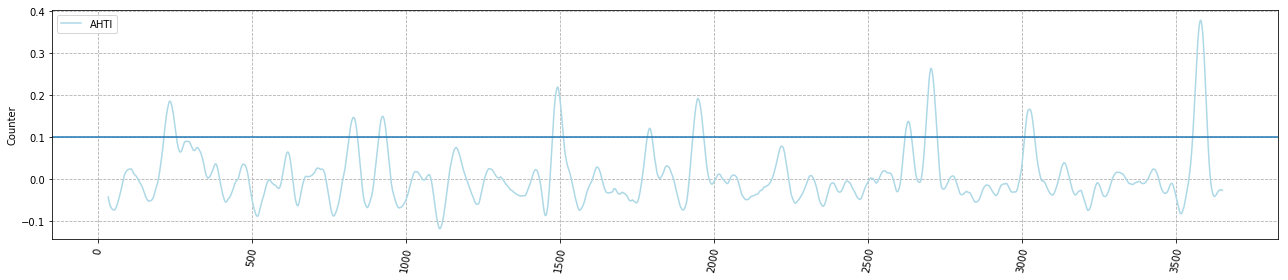

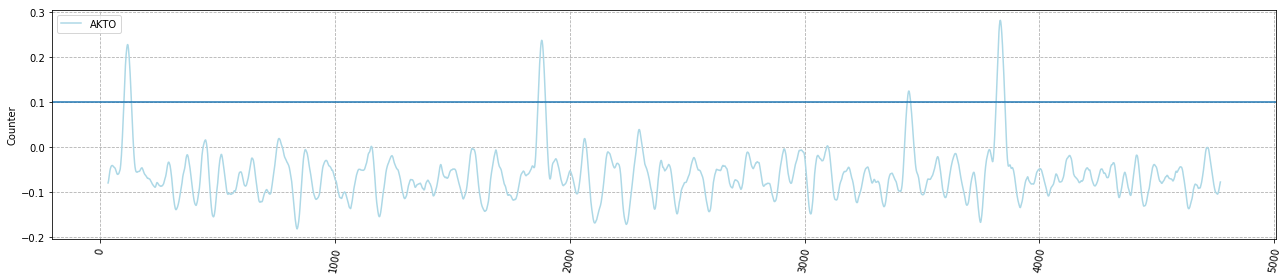

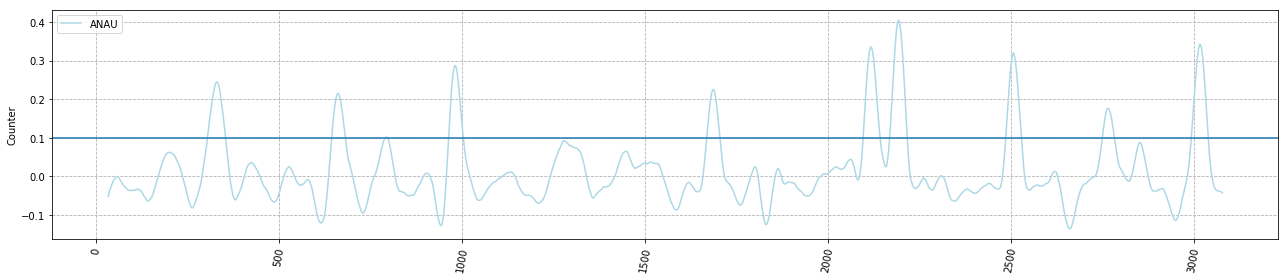

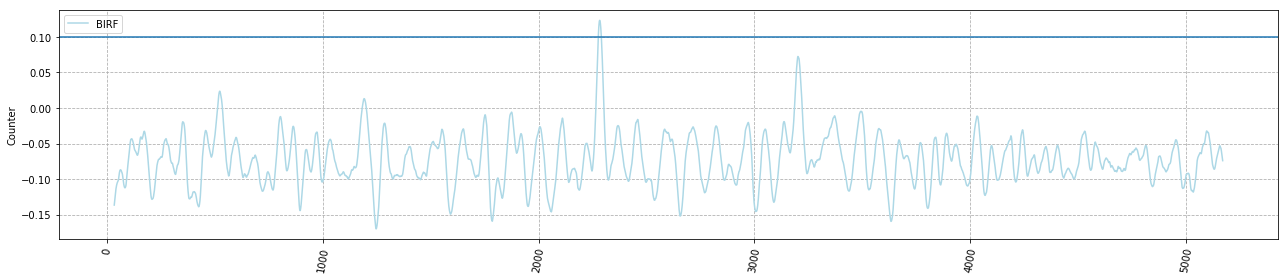

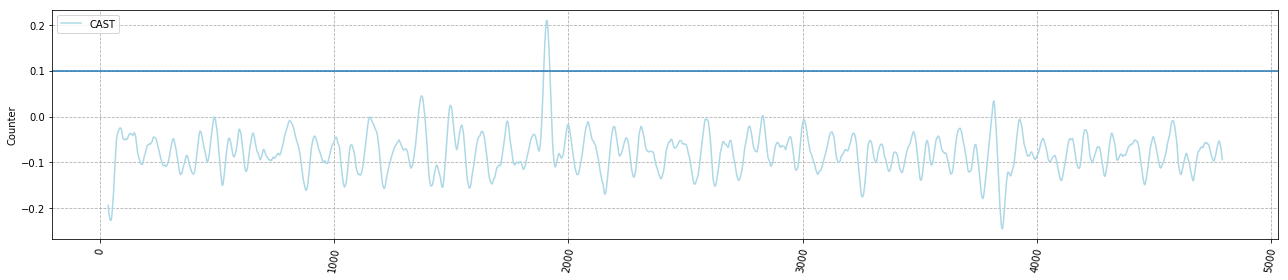

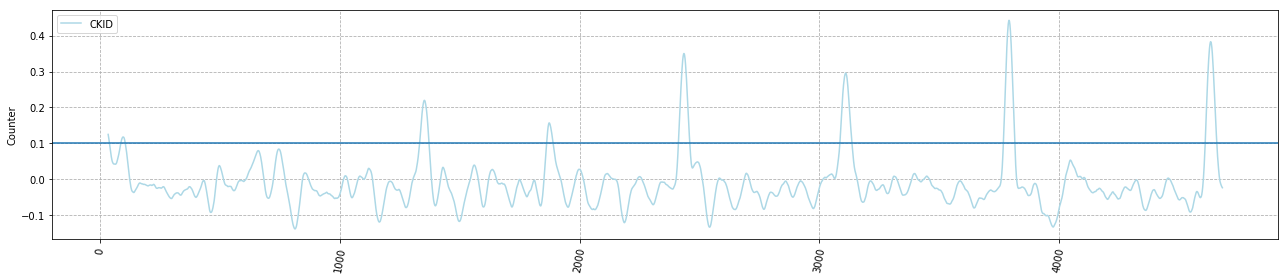

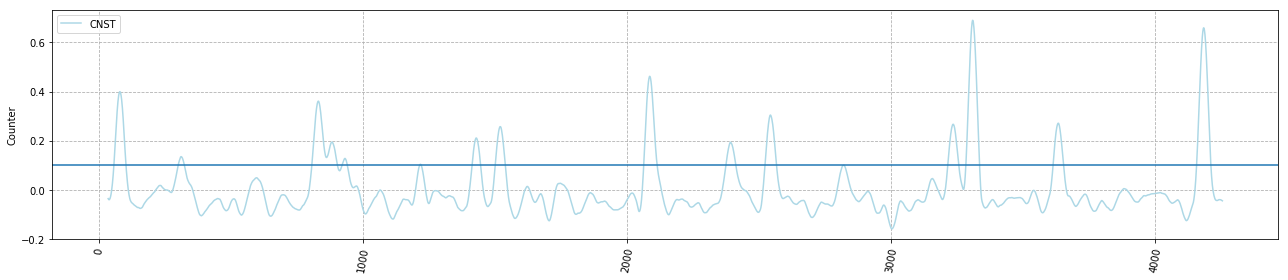

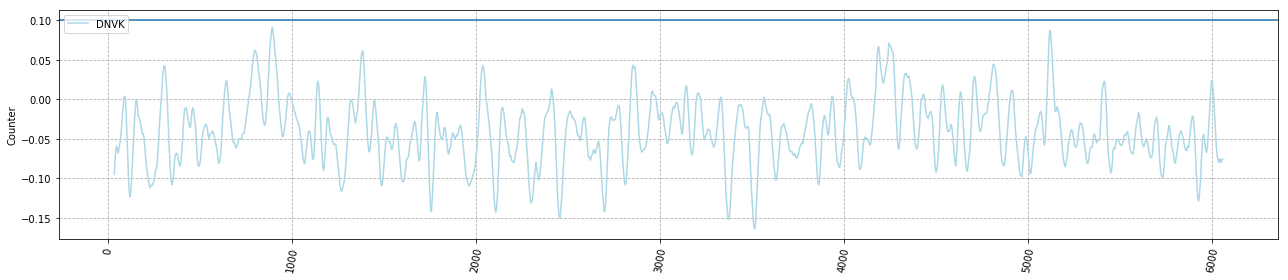

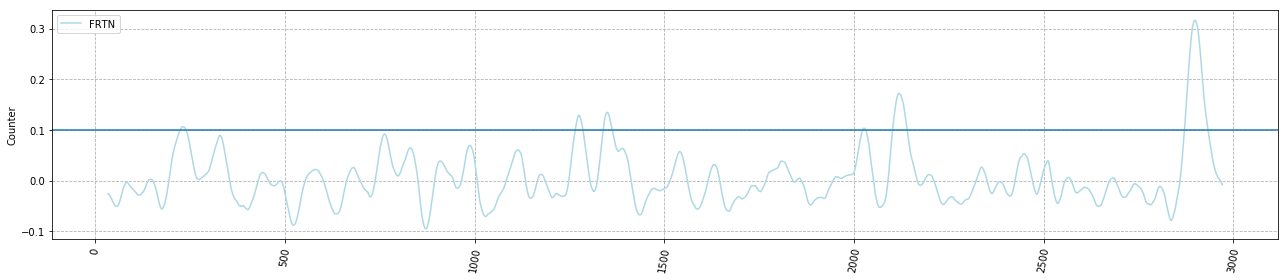

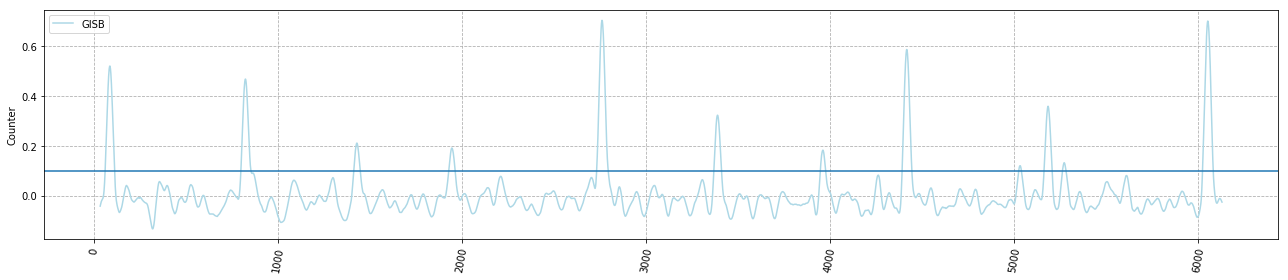

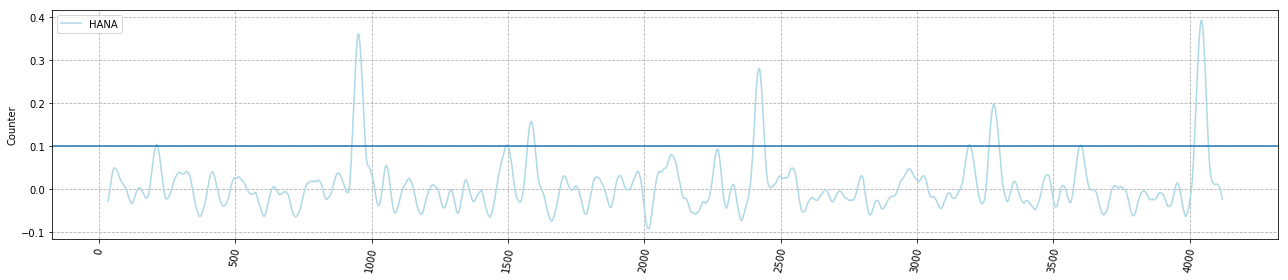

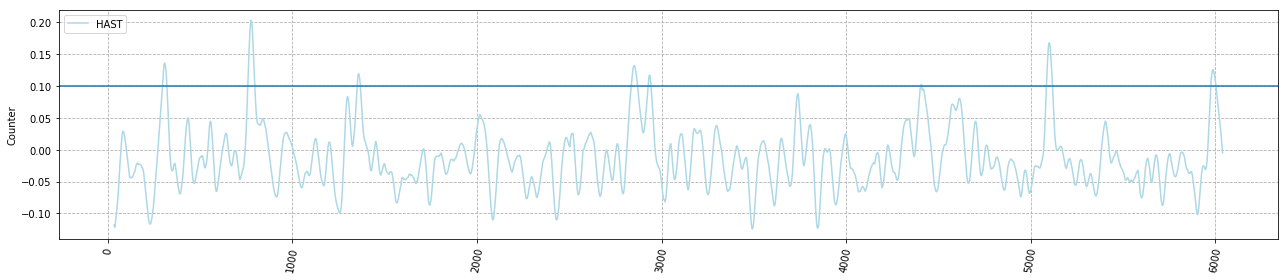

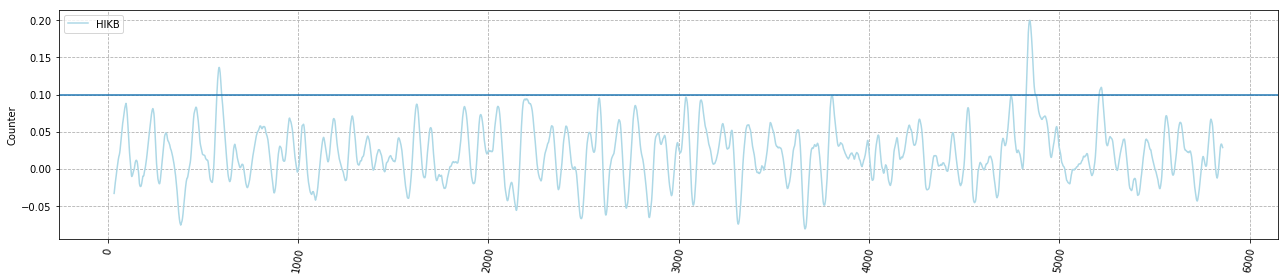

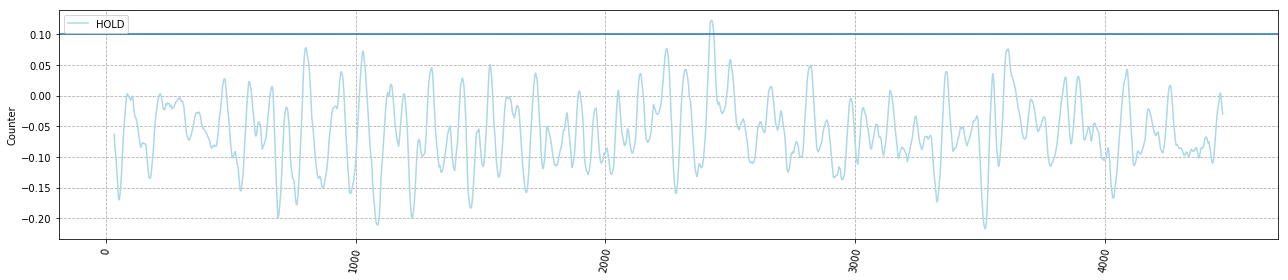

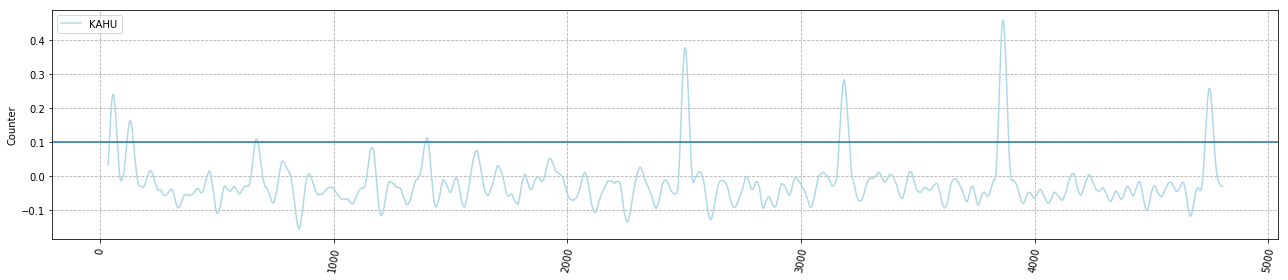

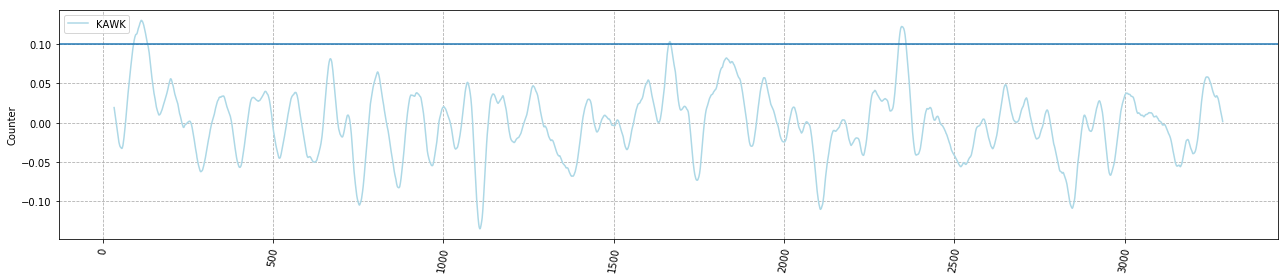

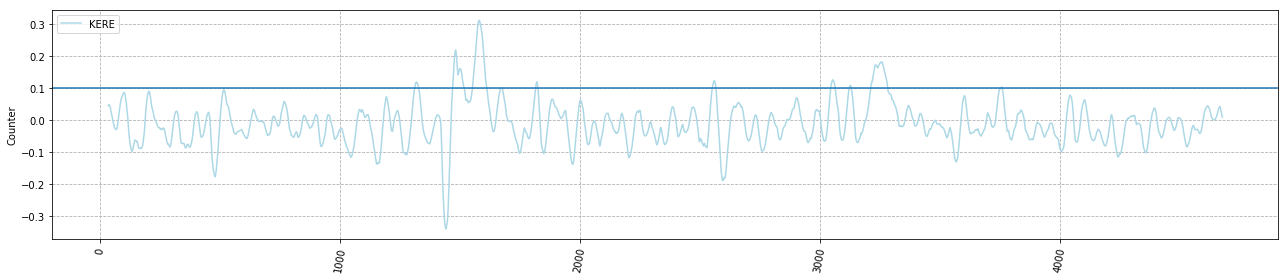

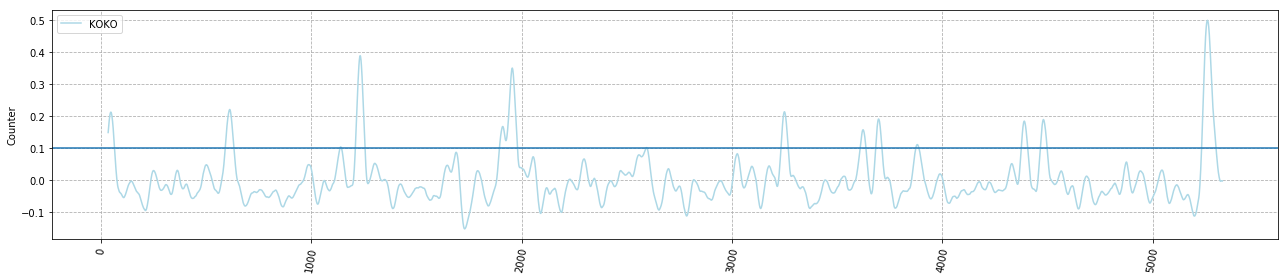

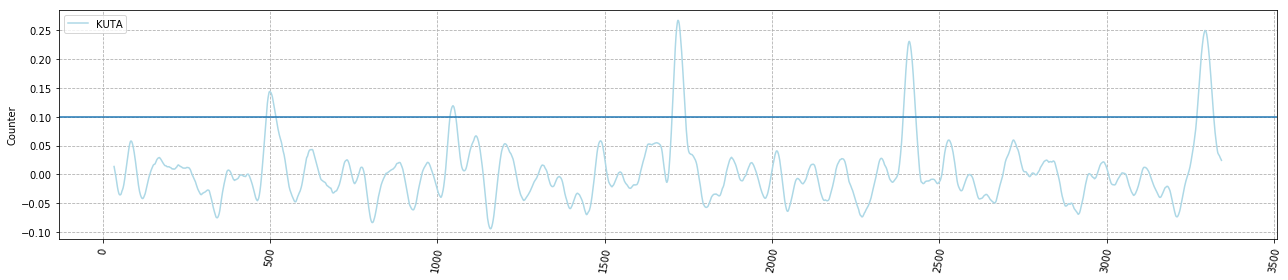

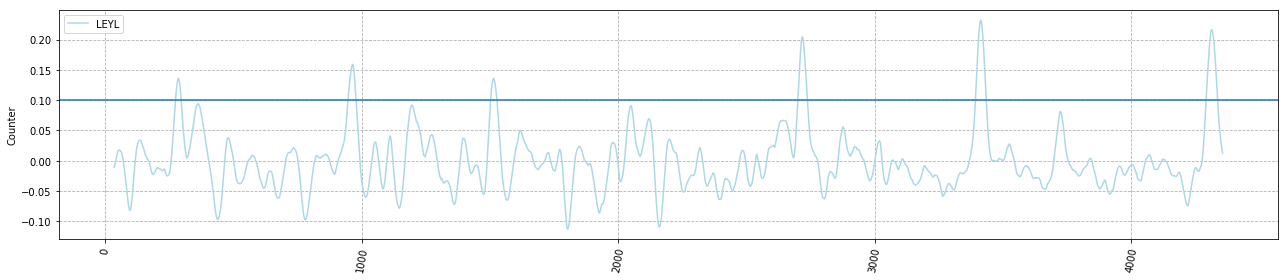

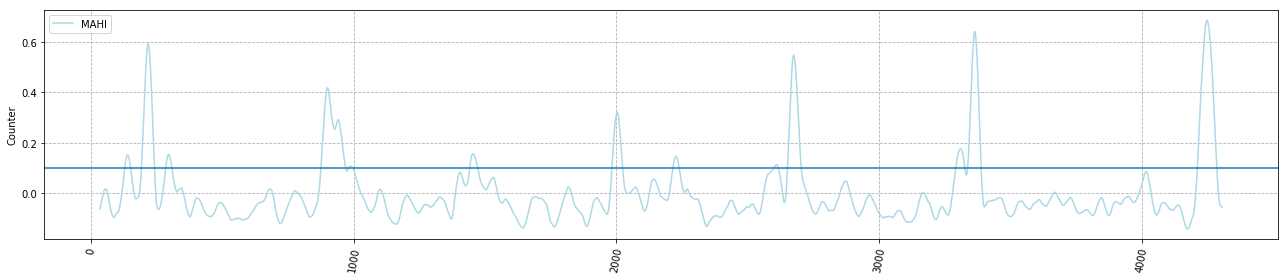

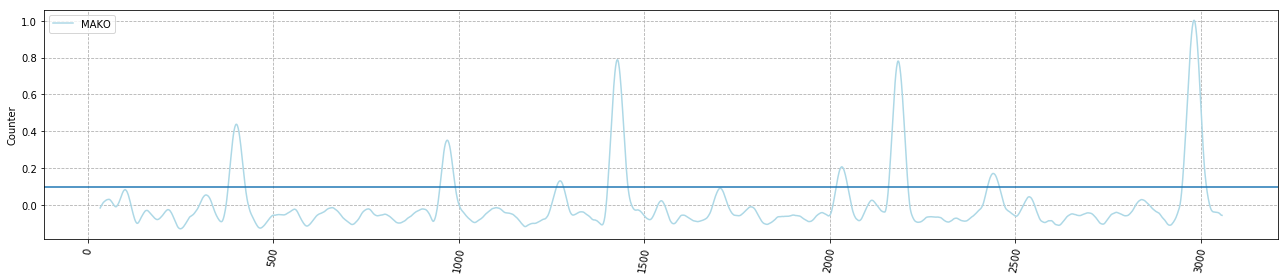

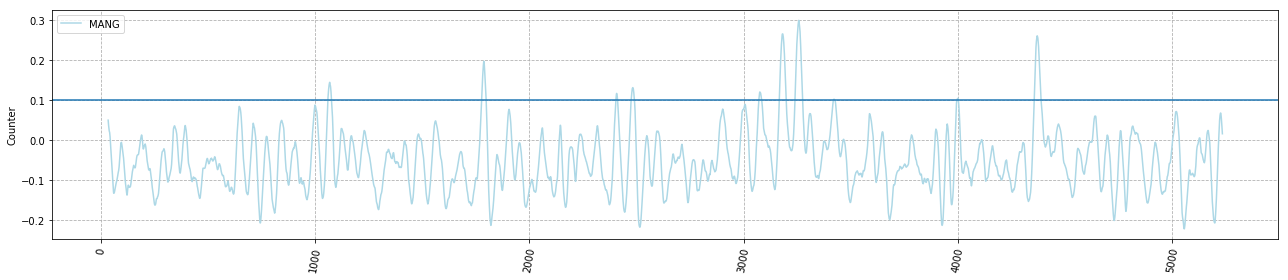

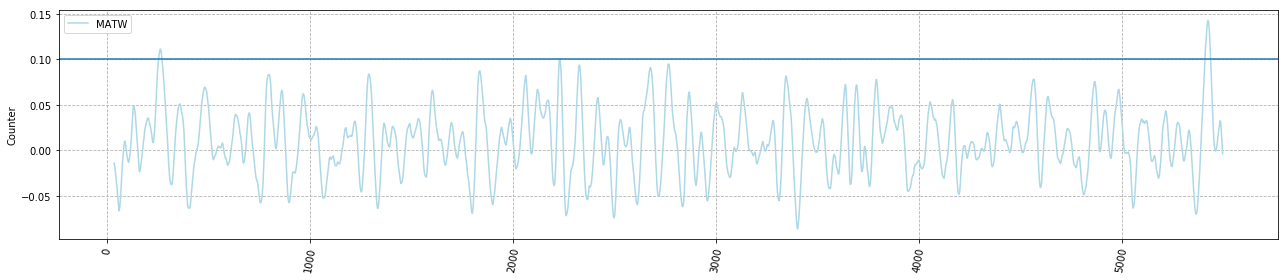

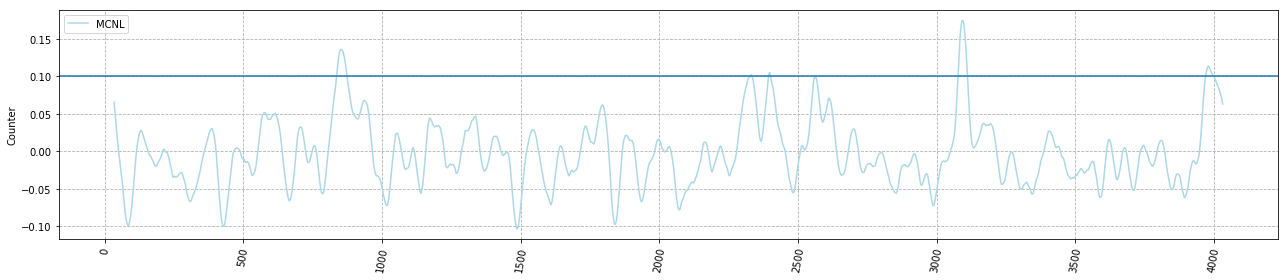

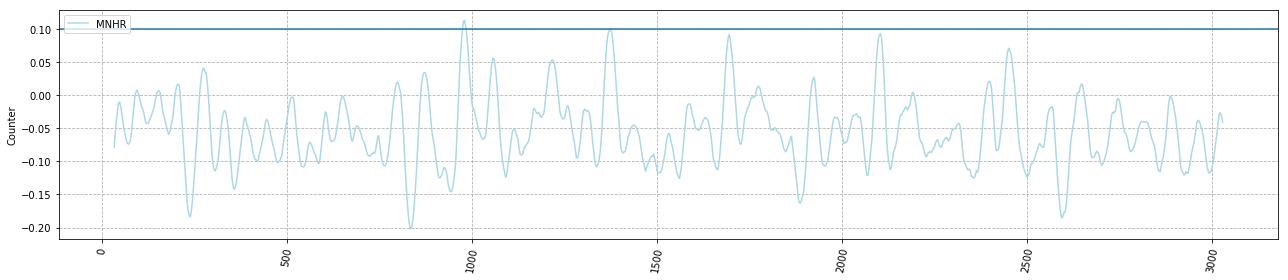

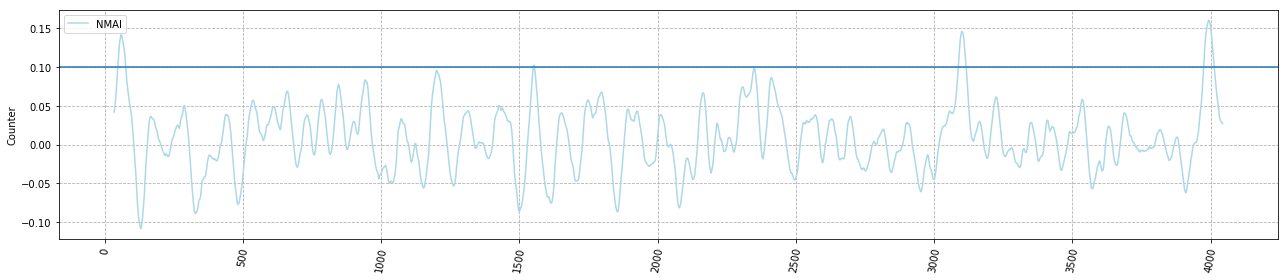

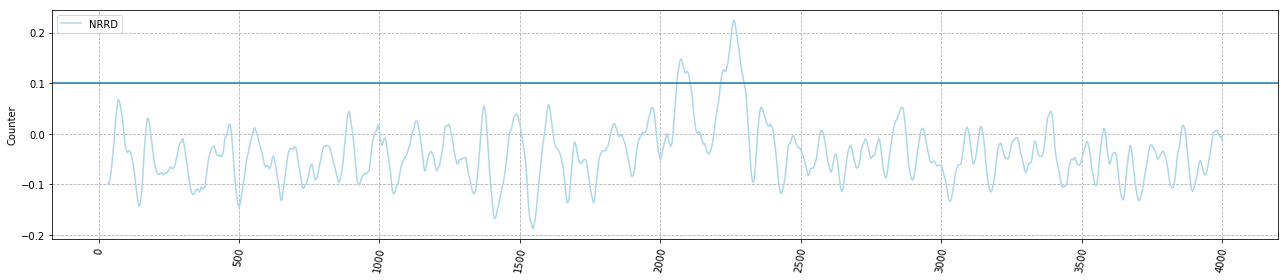

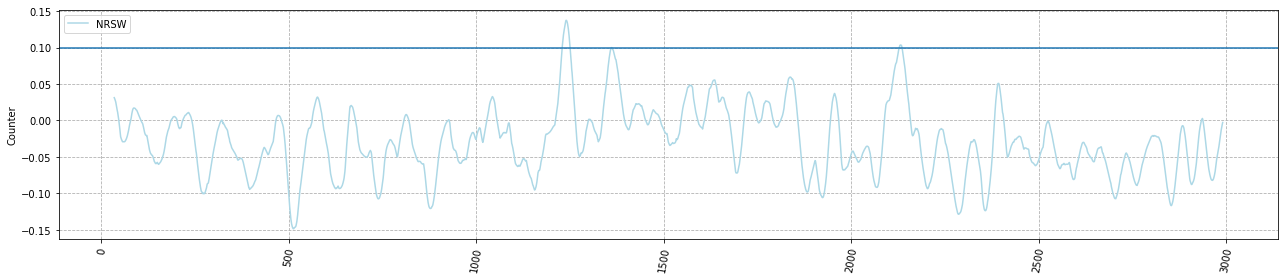

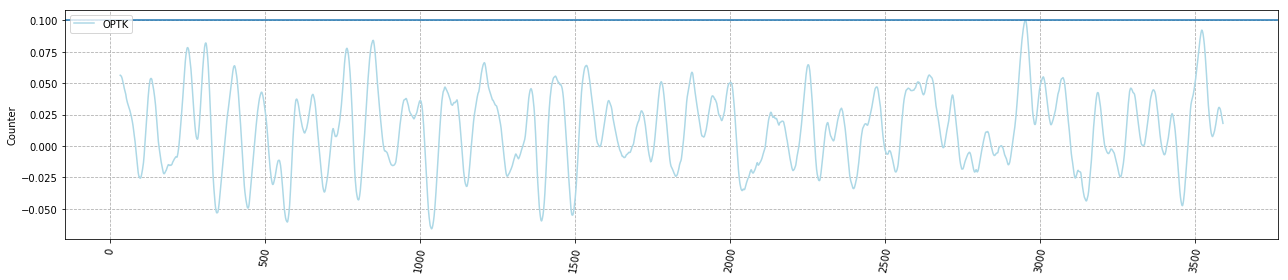

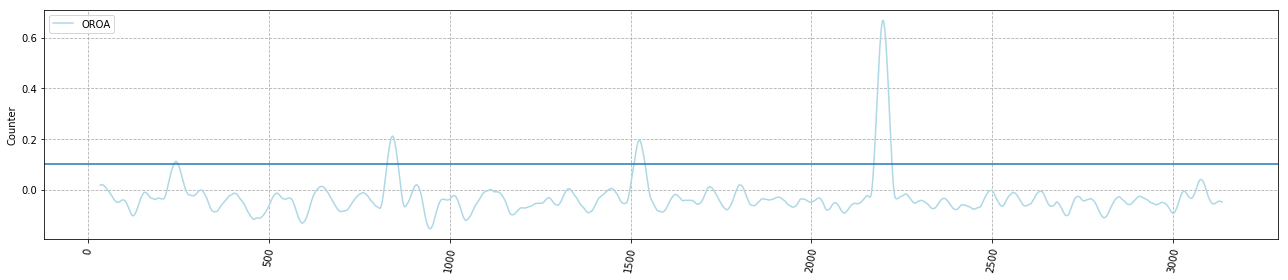

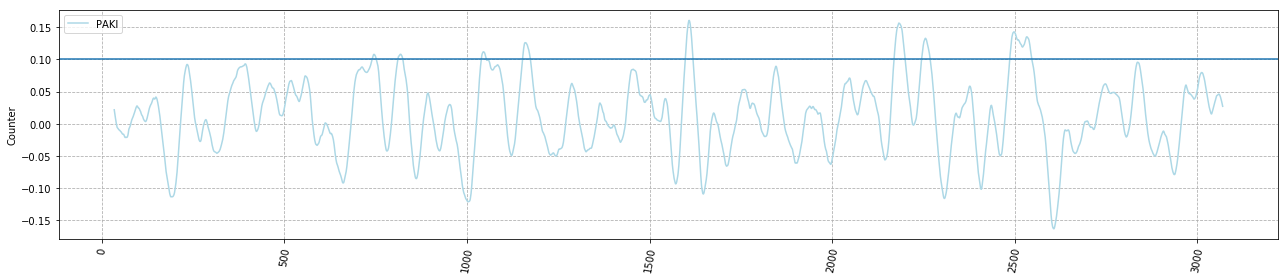

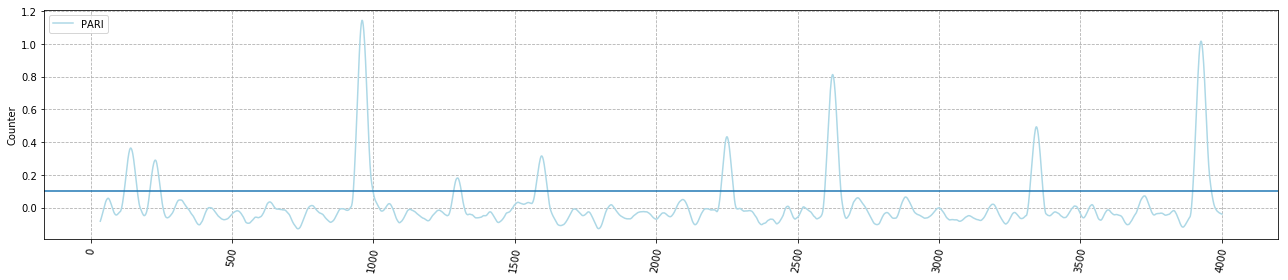

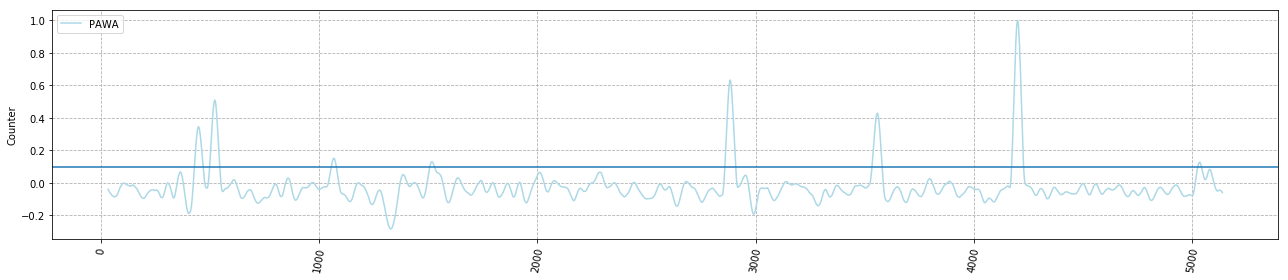

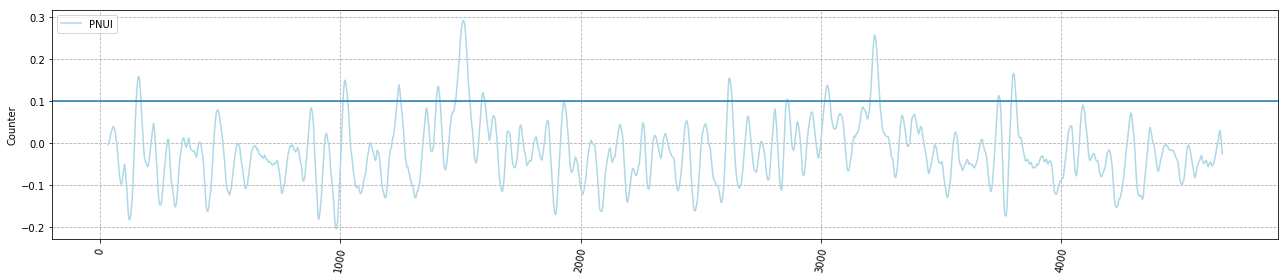

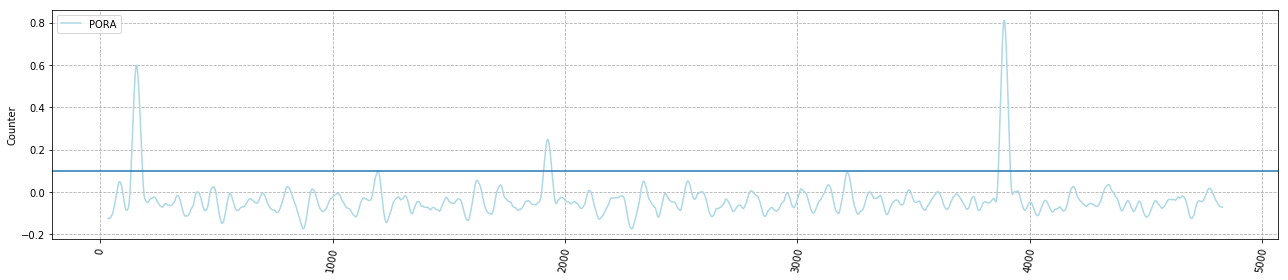

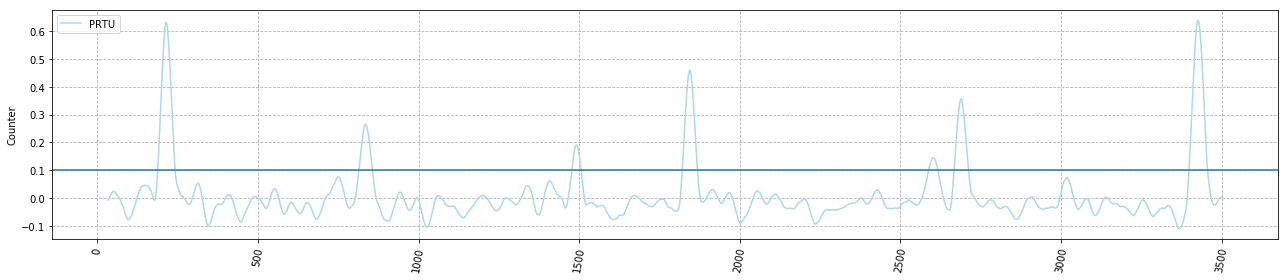

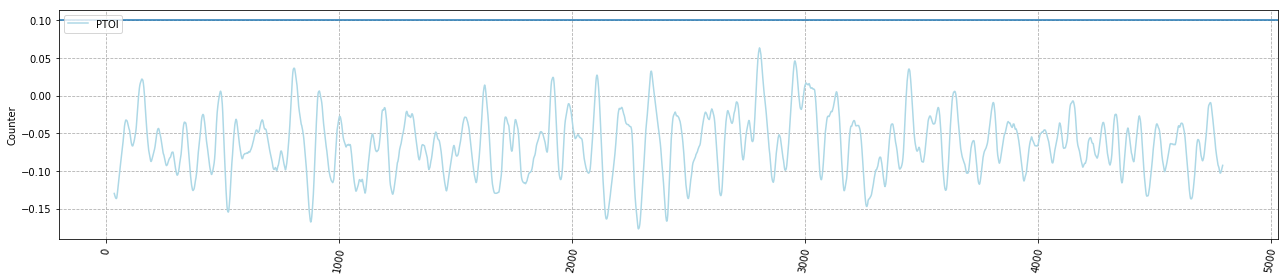

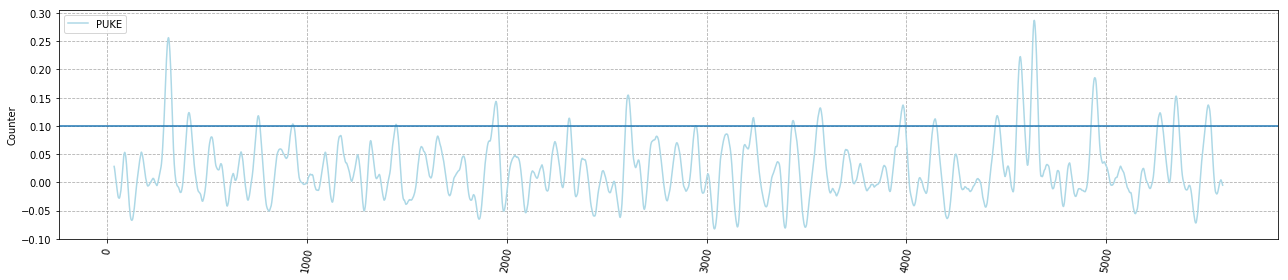

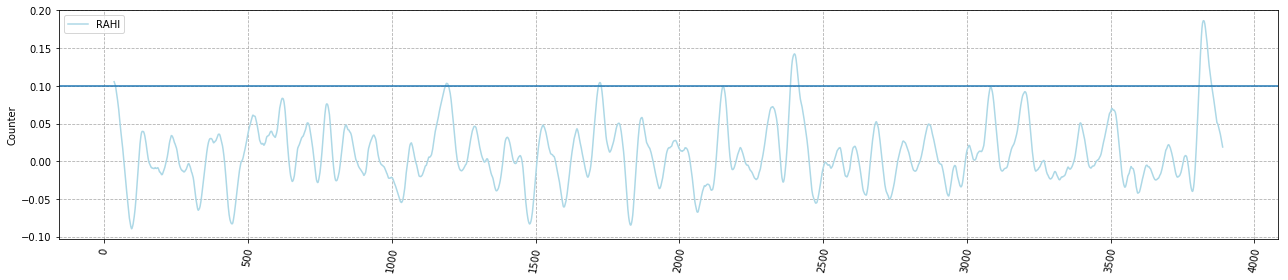

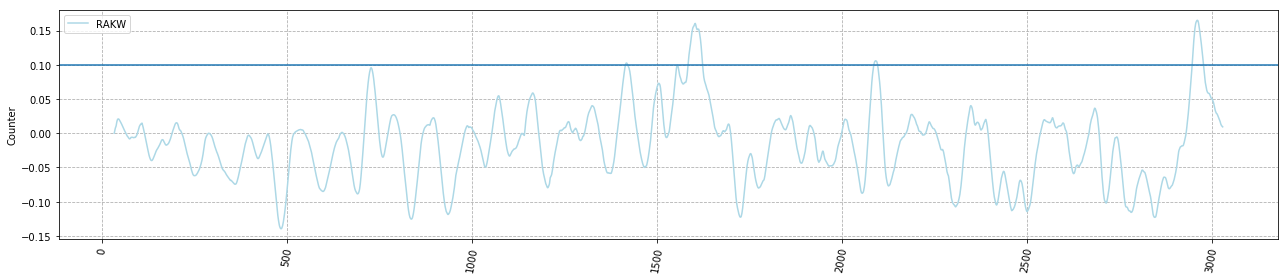

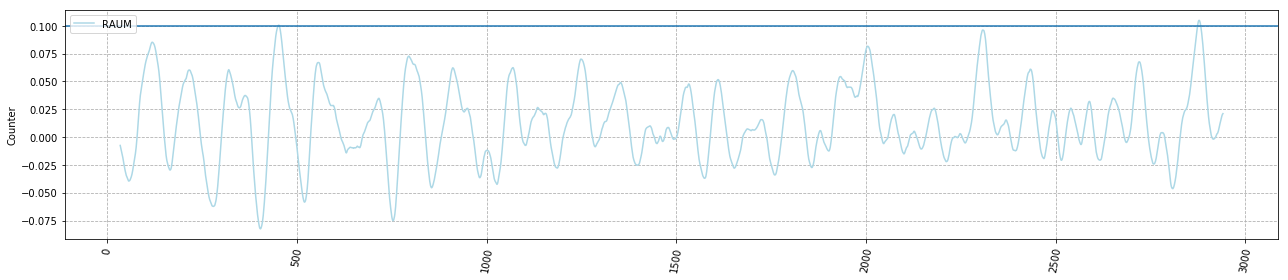

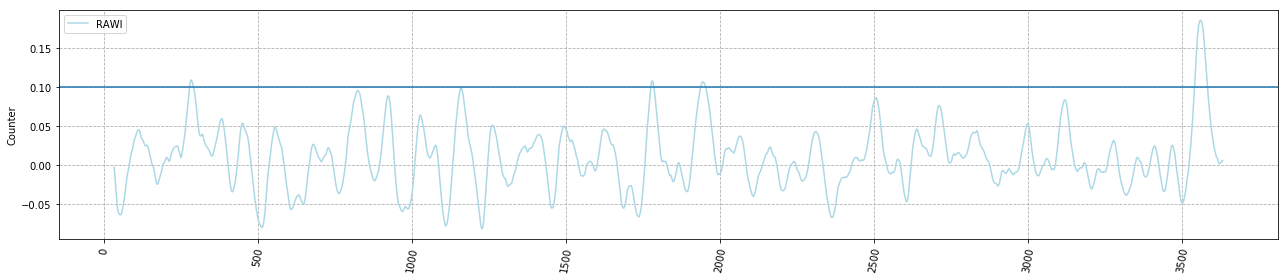

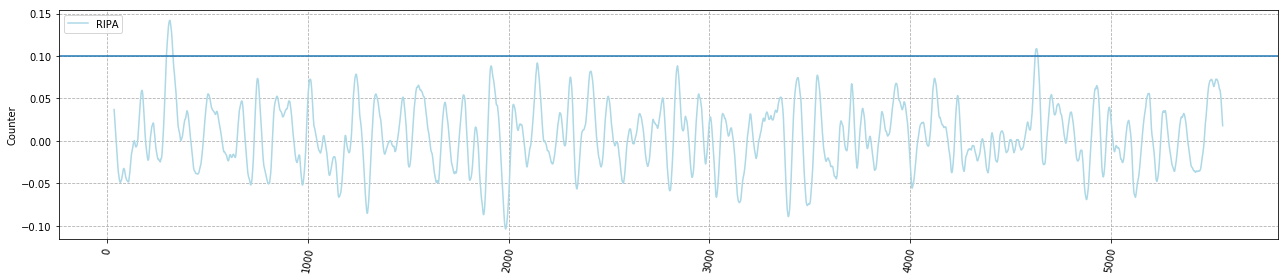

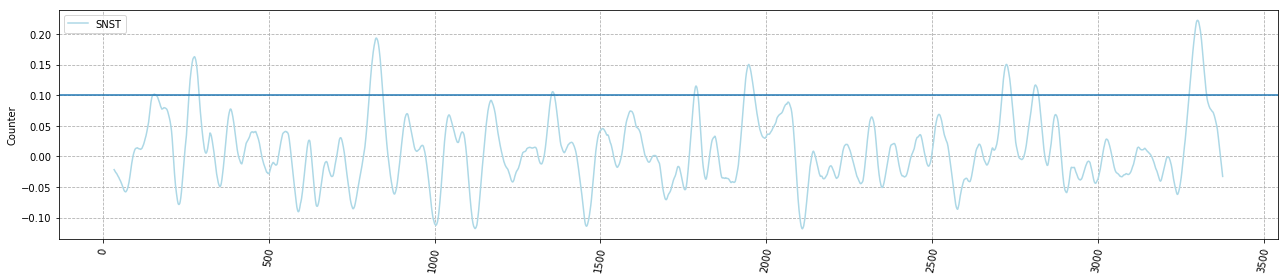

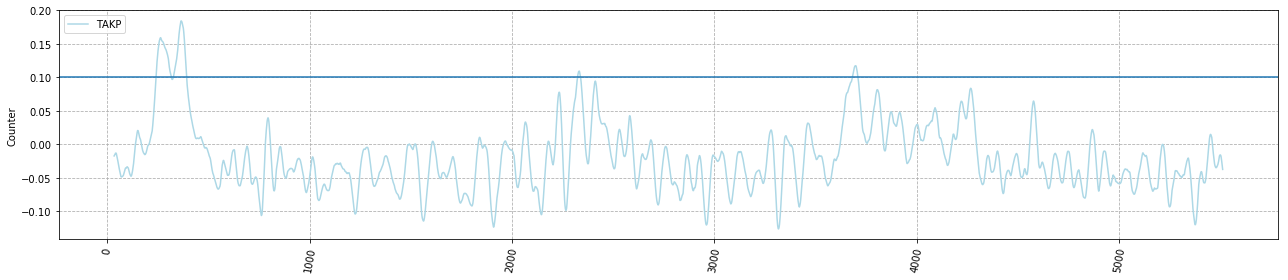

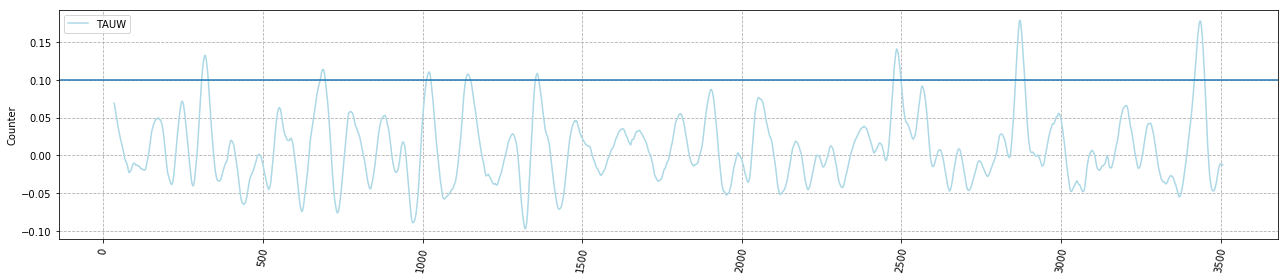

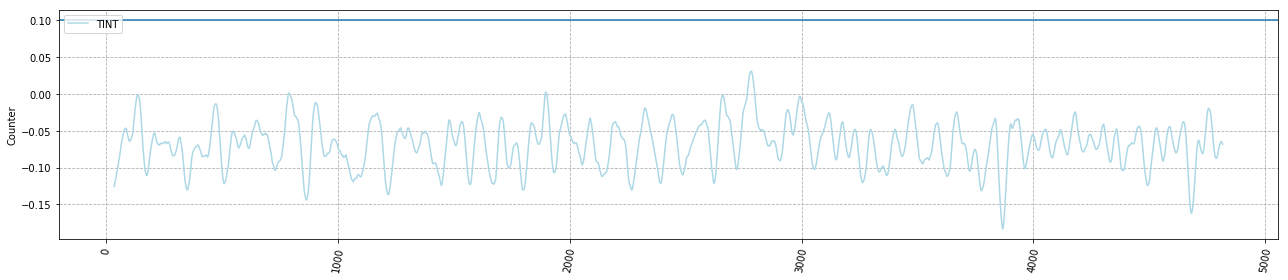

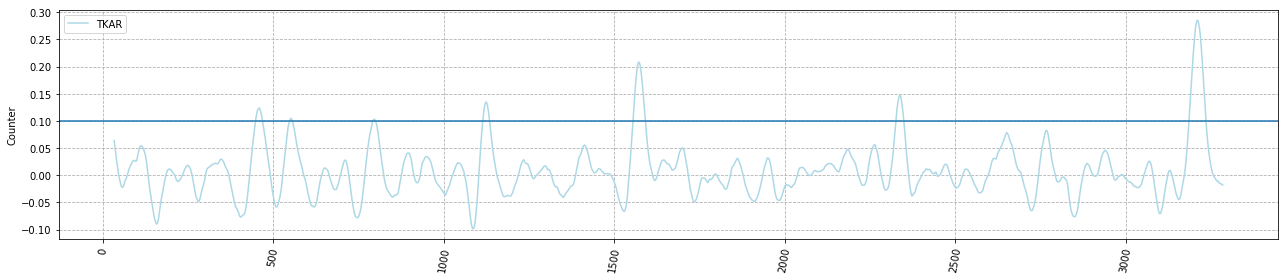

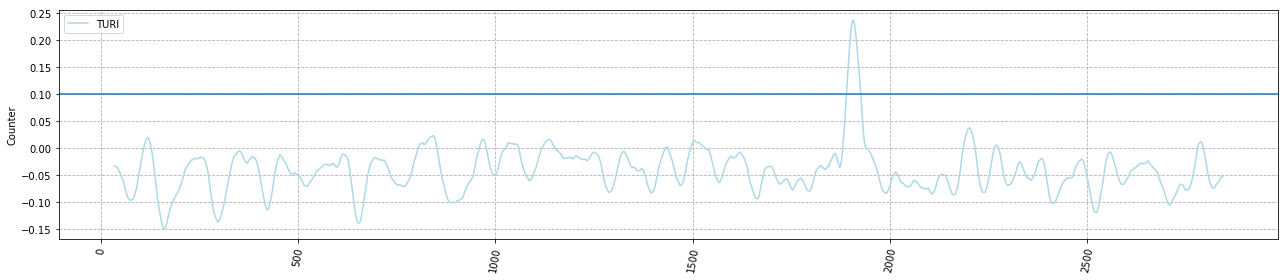

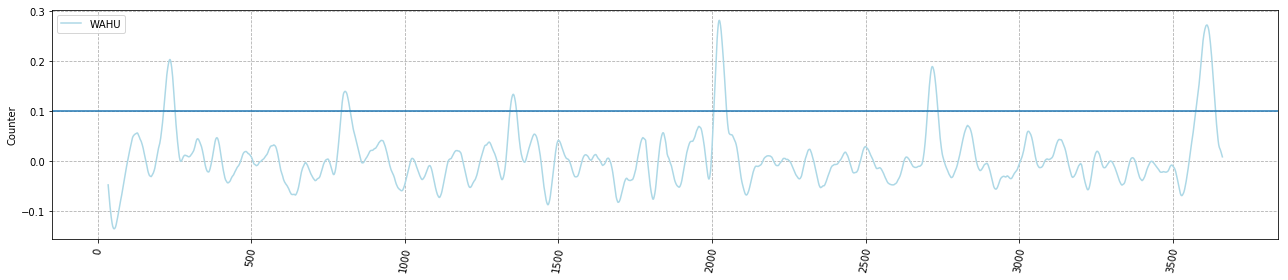

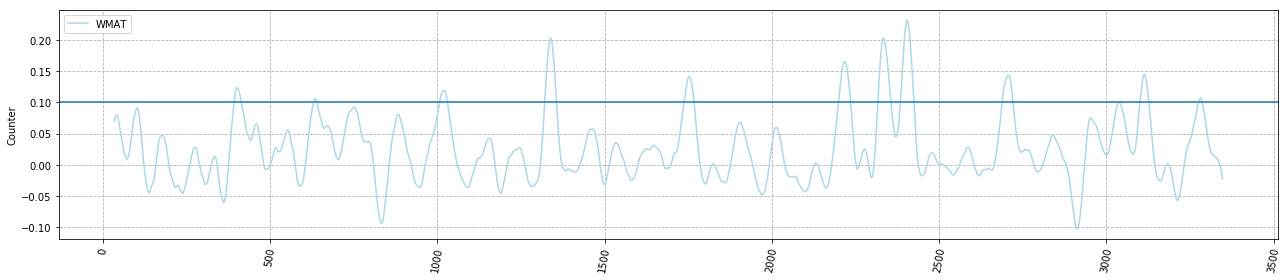

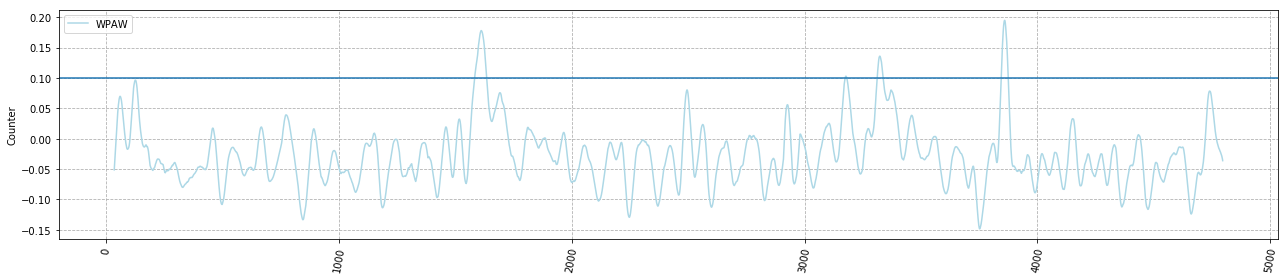

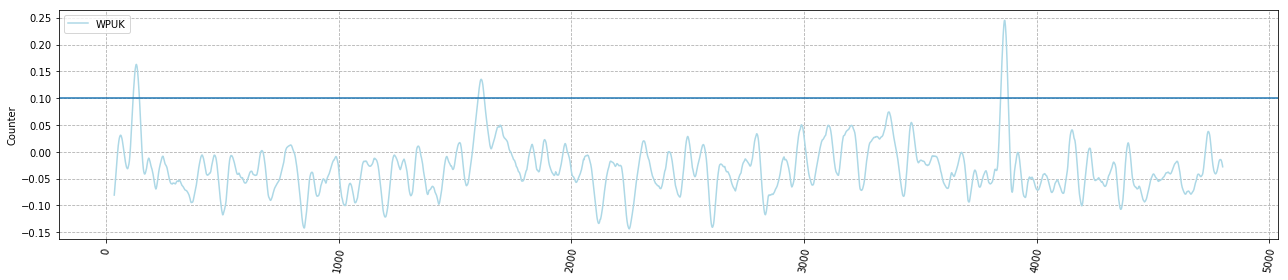

In [12]:
for i in stations_list:
#     globals()['slope_{0}'.format(i)].plot(y="slope",figsize=(20,10),subplots=True,color='tab:orange',layout=(3,1),label=i)

    plt.figure()
    plt.plot(globals()['slope_{0}'.format(i)].index,globals()['slope_{0}'.format(i)]['rolling'],'-', color='lightblue',label=i)
    # plt.plot_date(visitors2['Date'],visitors2['Visitors'].rolling(5).mean(),'g-',label="Unique Visitors- mean")

    # plt.axvline(x='2018-07-31', color='r', linestyle='--',label="CWB turn off")
    plt.legend(loc=2)
    plt.xticks( rotation= 80 )

    # Grids
    plt.gca().xaxis.grid(True, linestyle='--')
    plt.gca().yaxis.grid(True, linestyle='--')

    plt.ylabel('Counter')
    plt.axhline(0.1)
    
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
    fig_size[0] = 18
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size

    plt.tight_layout()
    plt.plot()

    

## Create an extra column with events label

In [10]:
def Clasifier_events(df):
    """
    This function assign a value of 1 if there is an event, or 
    0 is not
    """
    df.loc[df['rolling'] >= 0.1, 'Event'] = 1.0
    df.loc[df['rolling'] < 0.1, 'Event'] = 0.0
    return df



In [11]:
for i in stations_list:
    globals()['slope_{0}'.format(i)] = Clasifier_events(globals()['slope_{0}'.format(i)])

In [12]:
slope_AKTO.head()

intercept     slope  rolling  Event
0  149.831286 -0.144546      NaN    NaN
1  150.057849 -0.155087      NaN    NaN
2  150.063678 -0.153577      NaN    NaN
3  150.174885 -0.156073      NaN    NaN
4  150.218429 -0.156714      NaN    NaN

## PLot Events

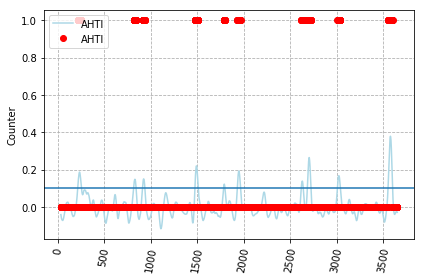

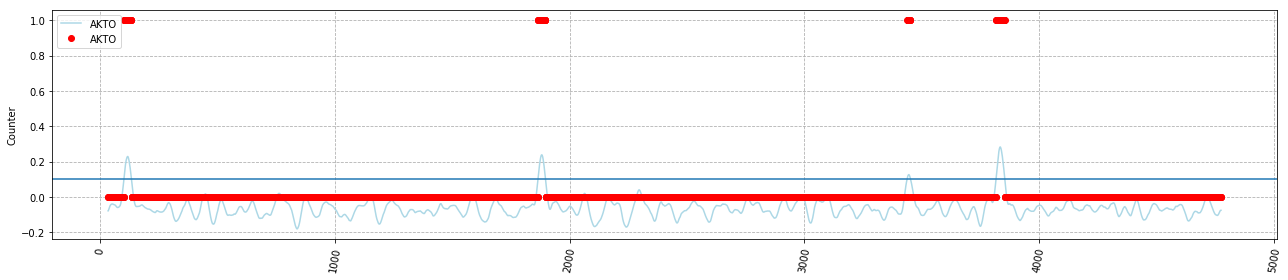

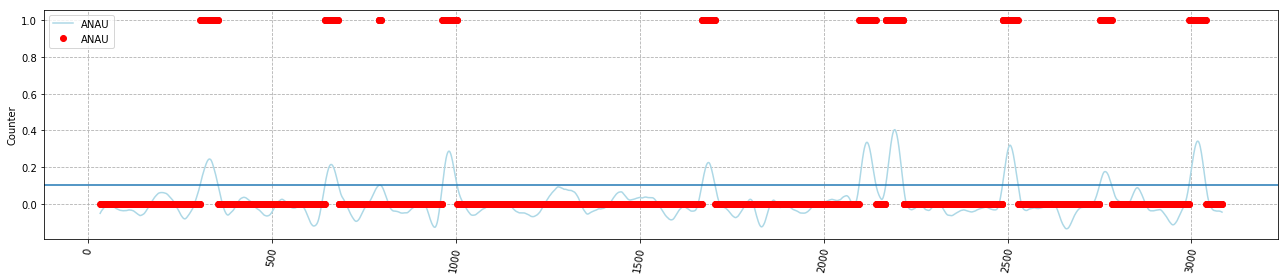

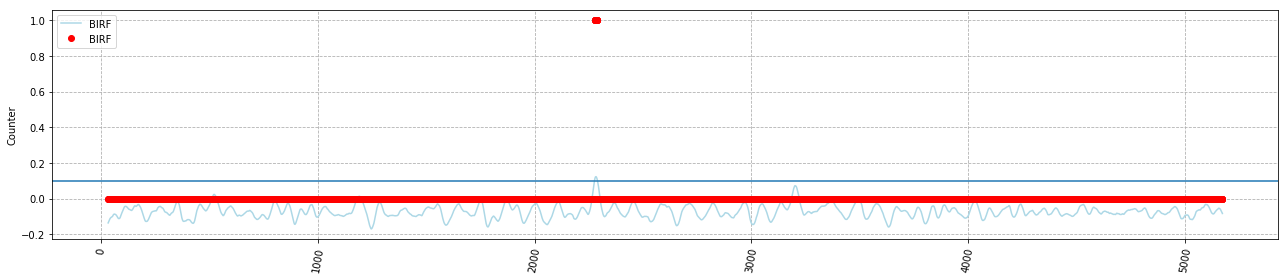

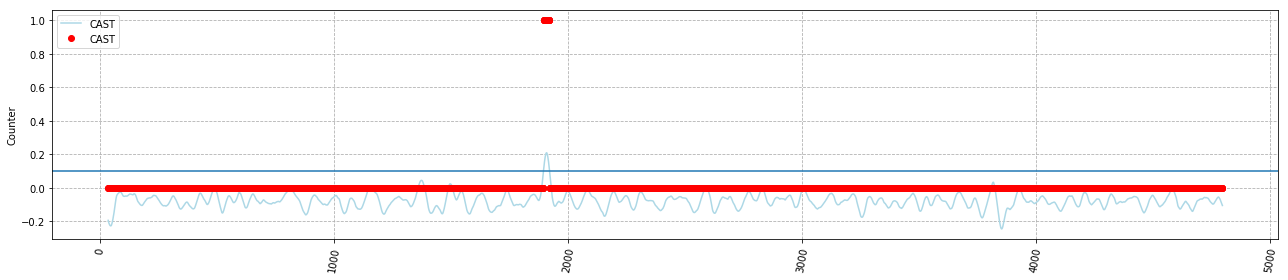

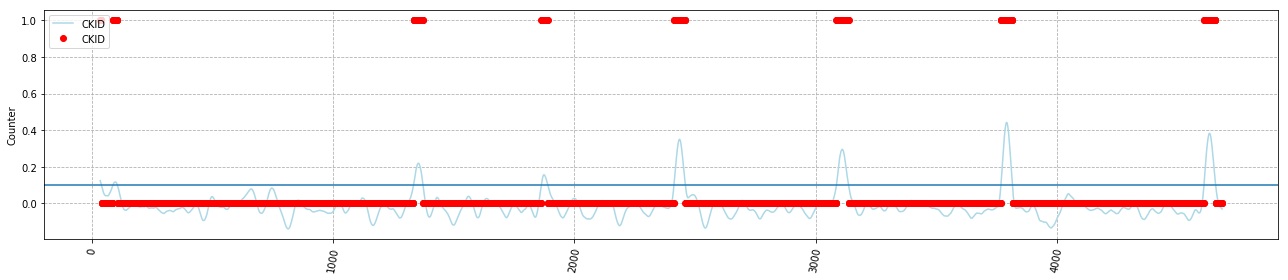

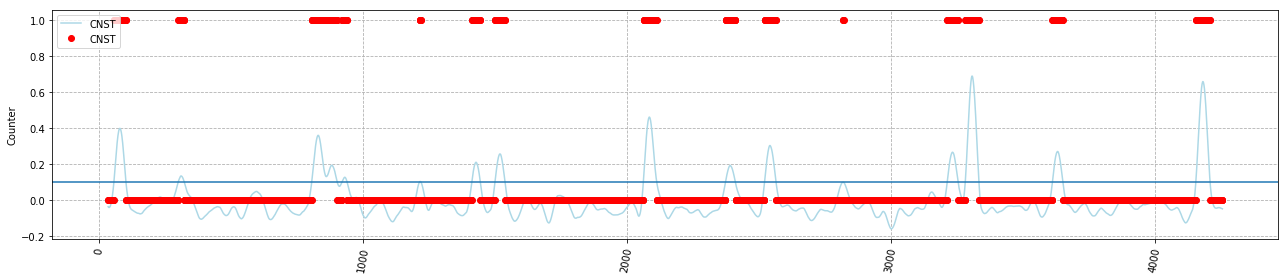

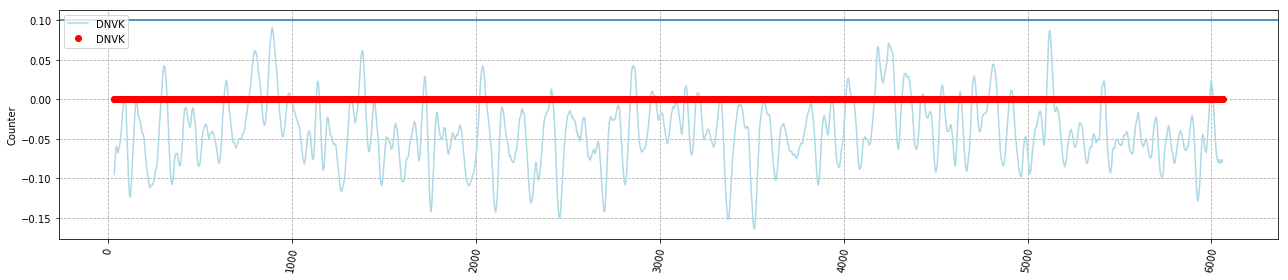

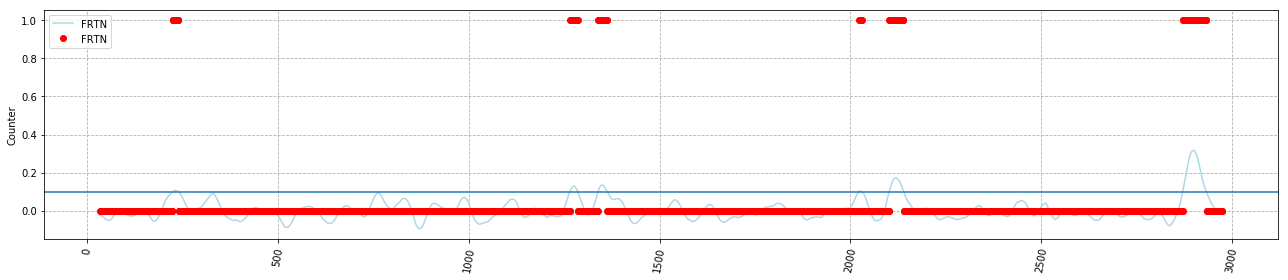

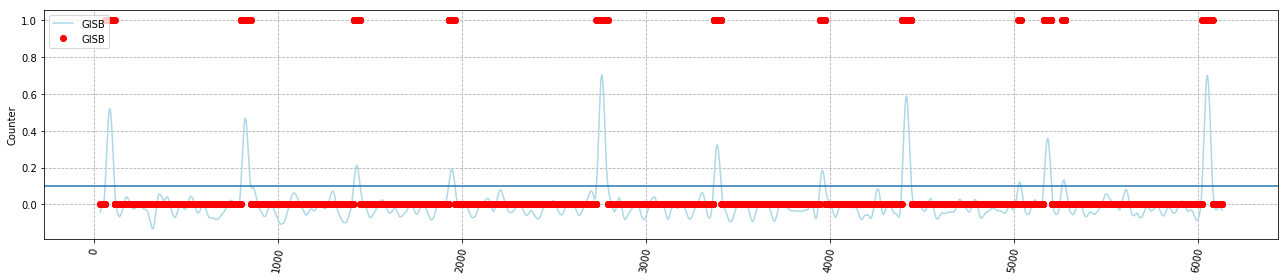

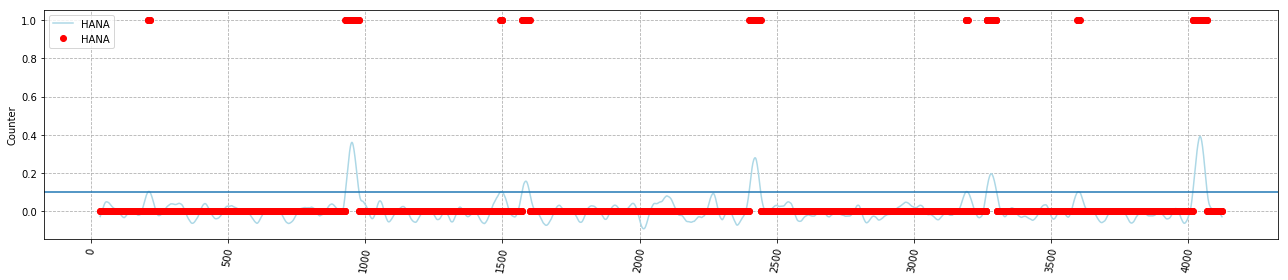

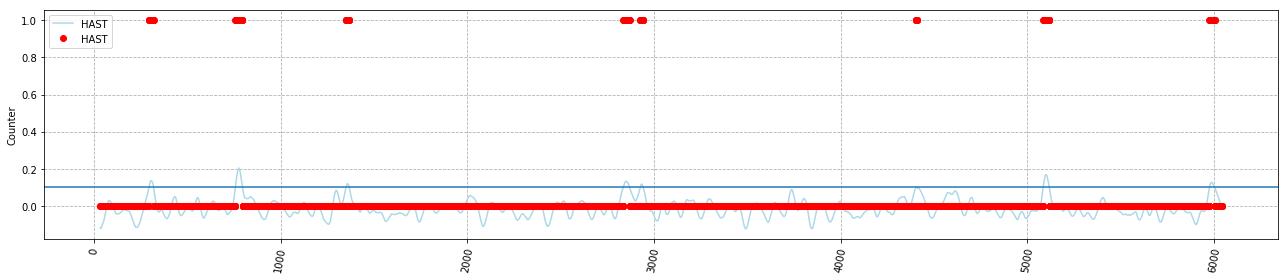

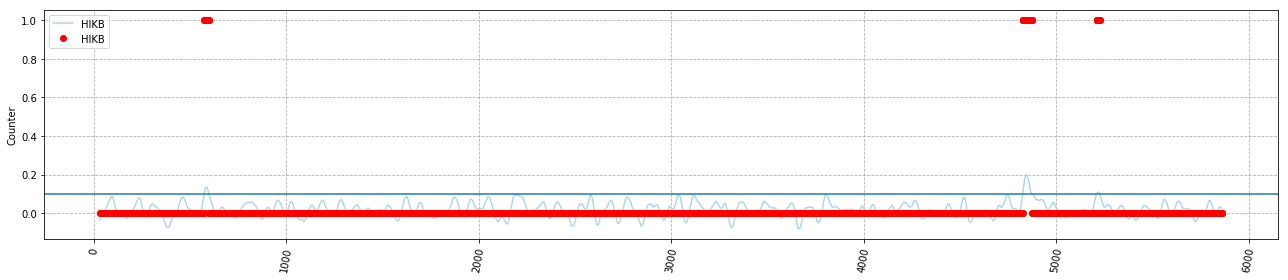

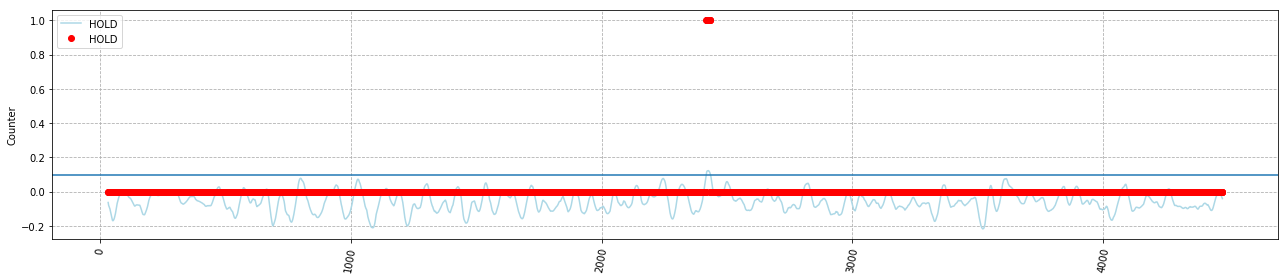

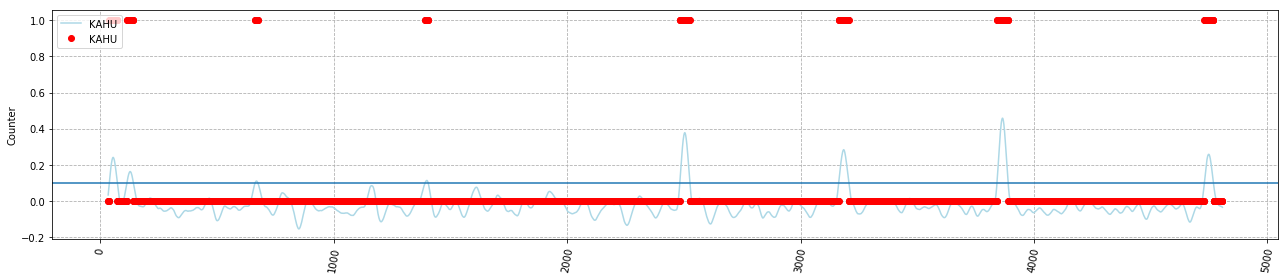

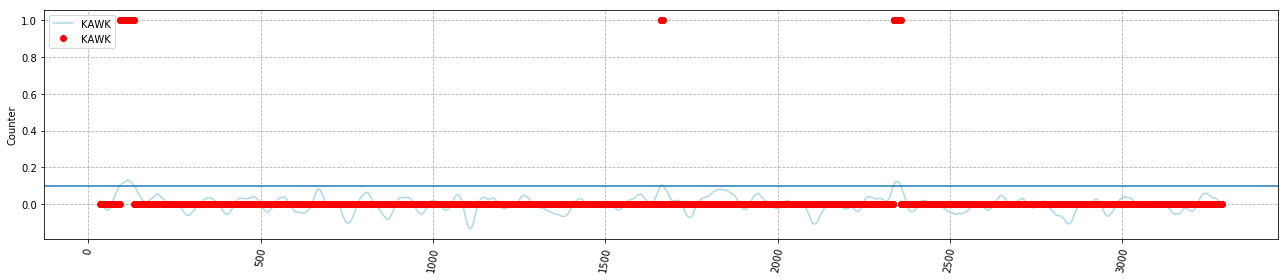

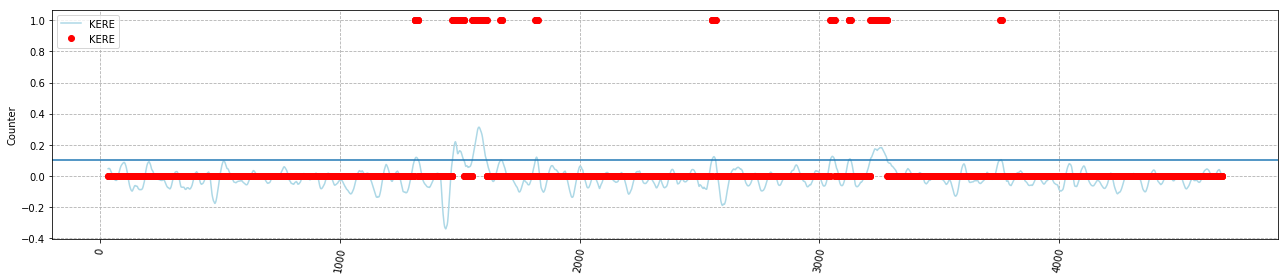

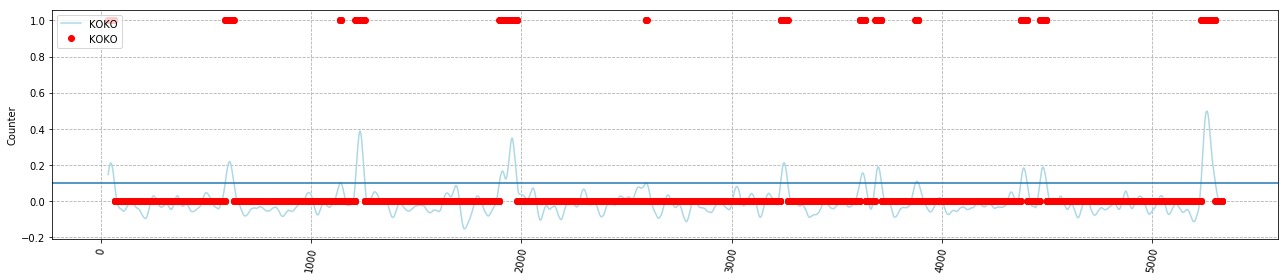

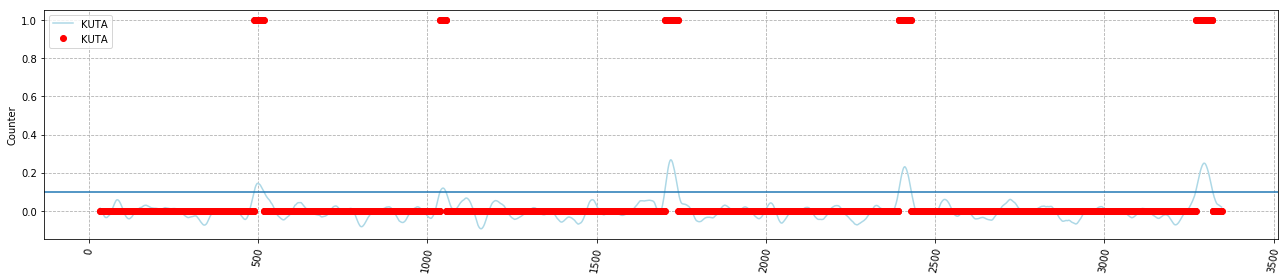

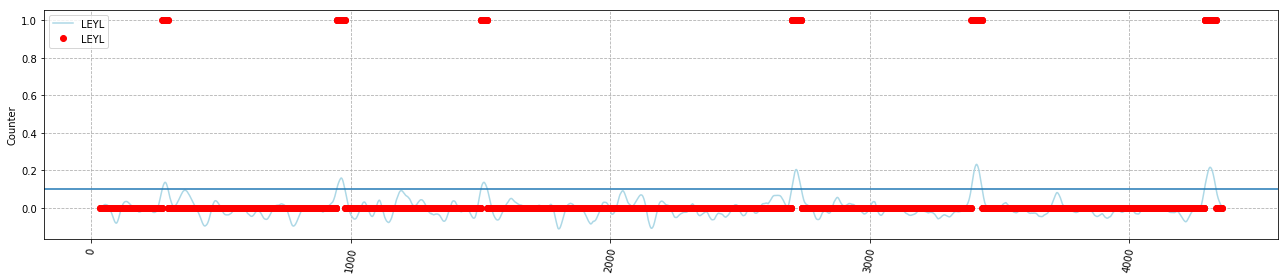

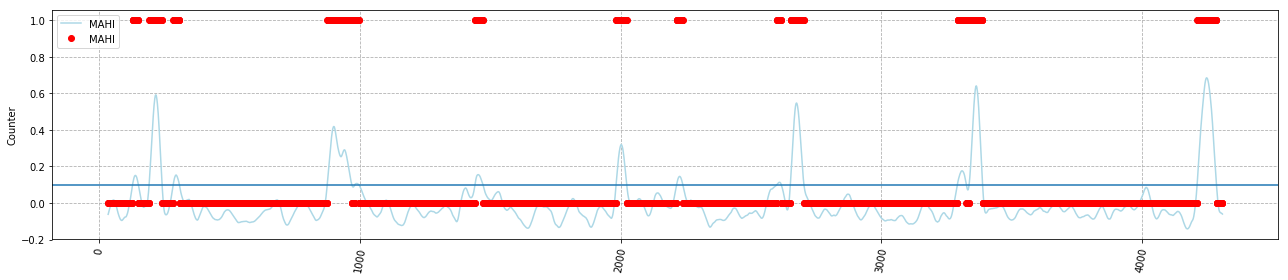

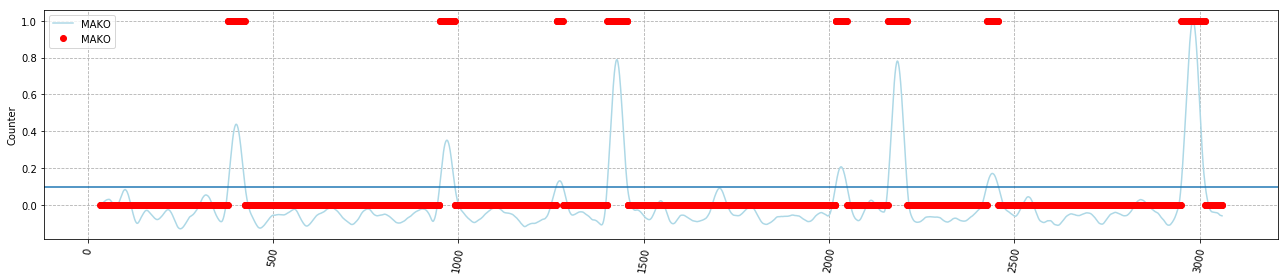

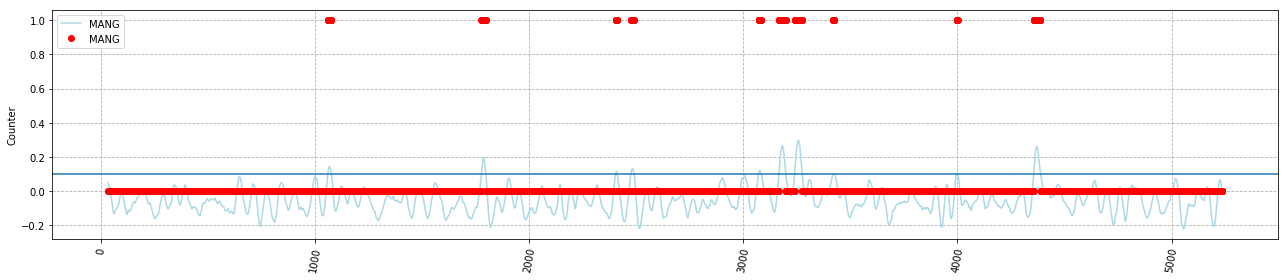

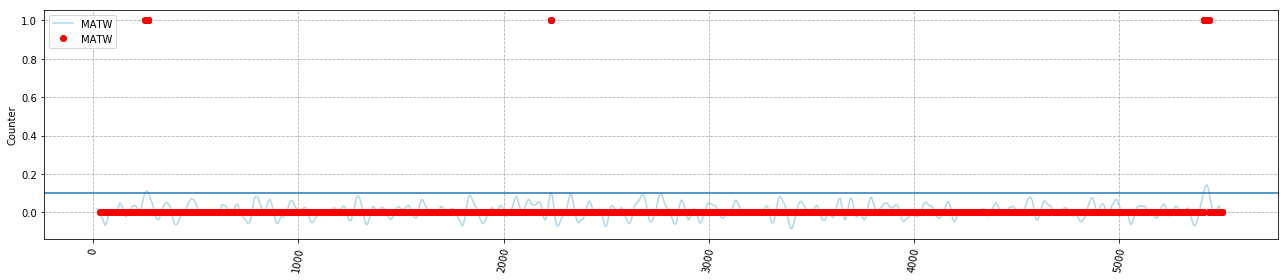

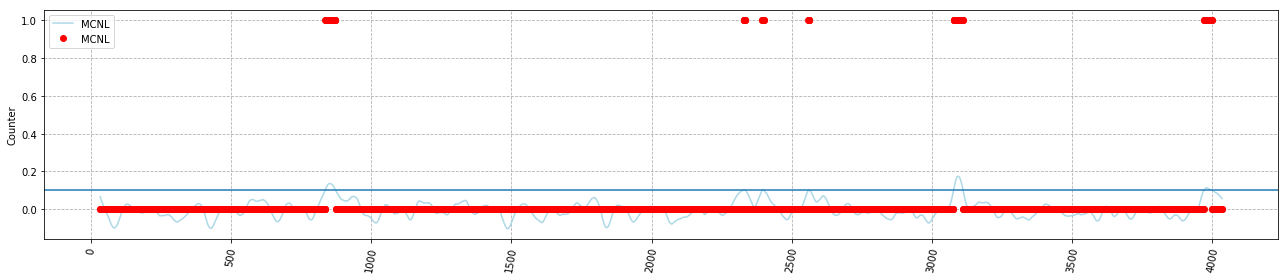

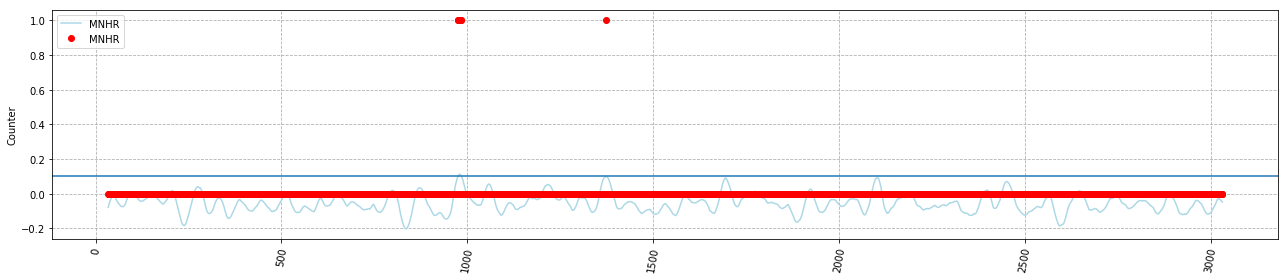

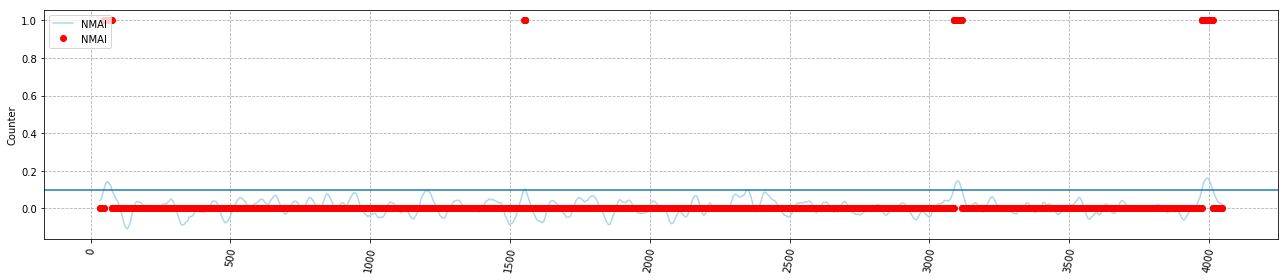

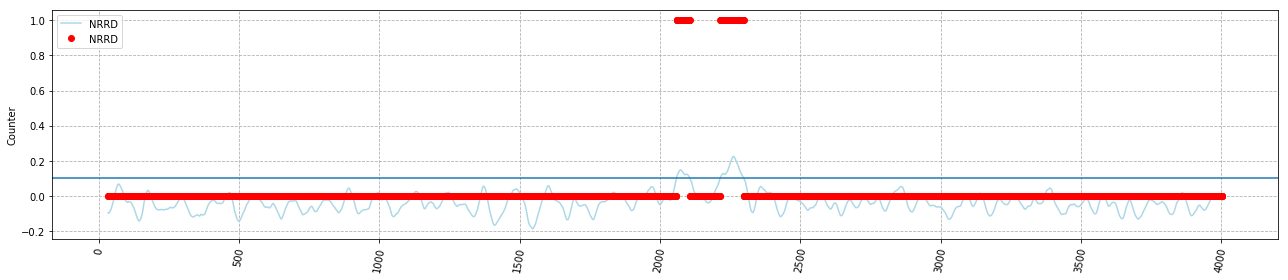

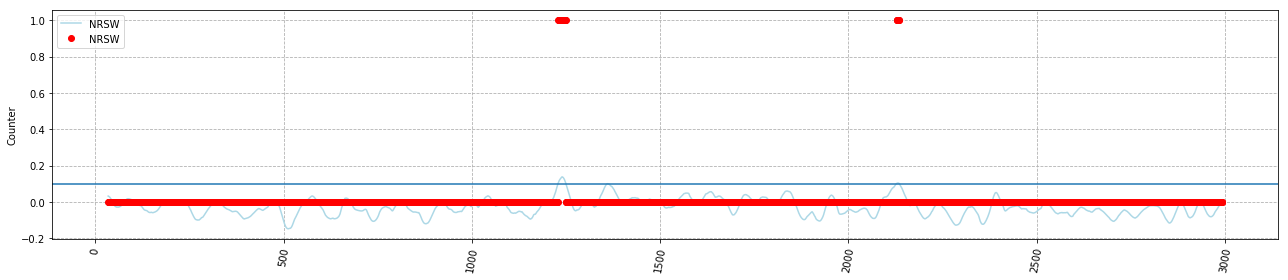

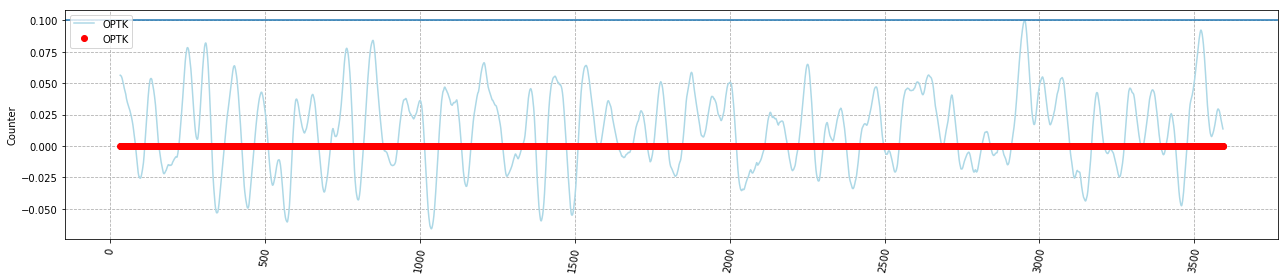

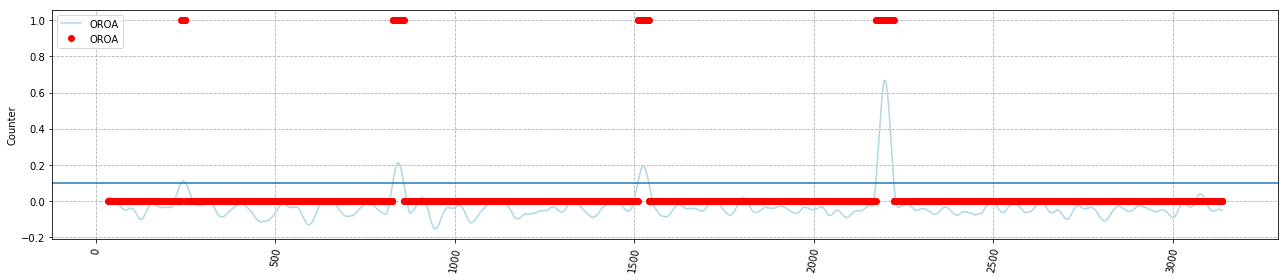

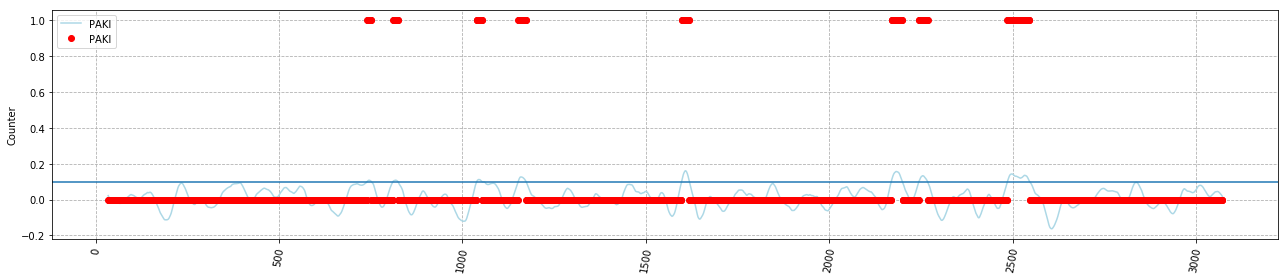

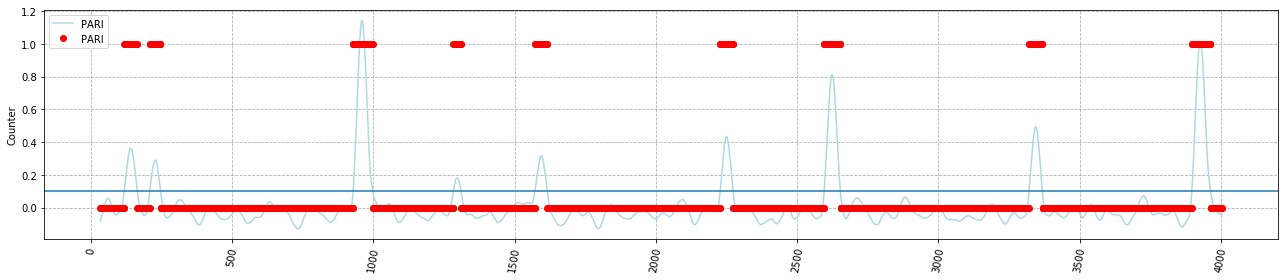

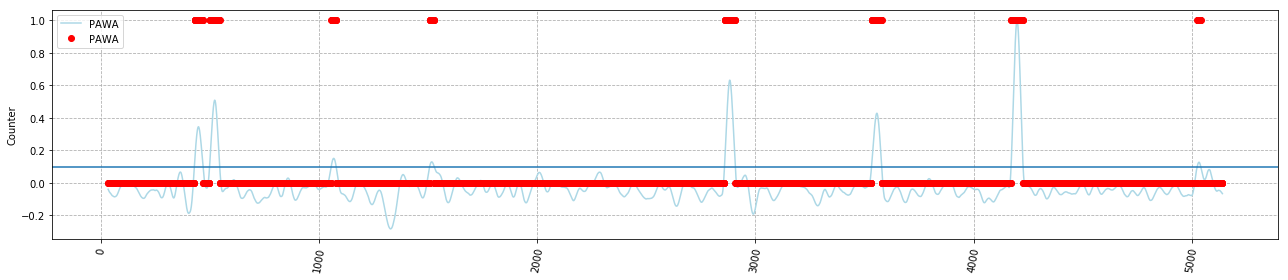

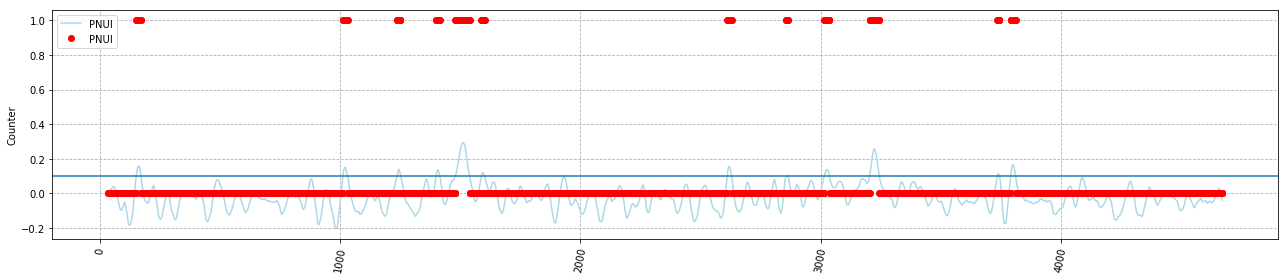

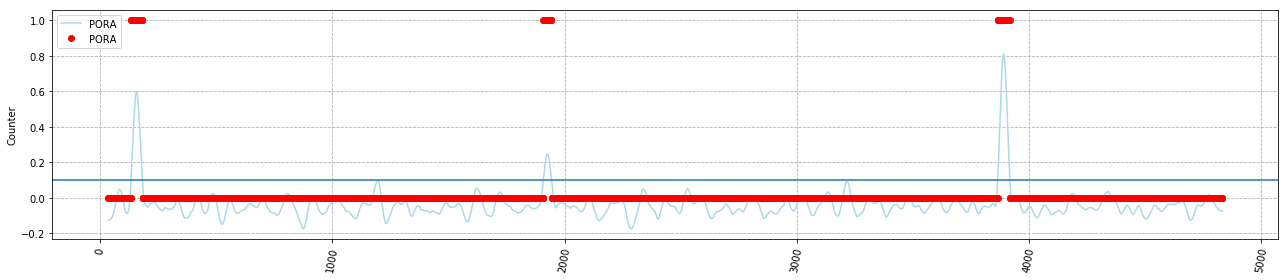

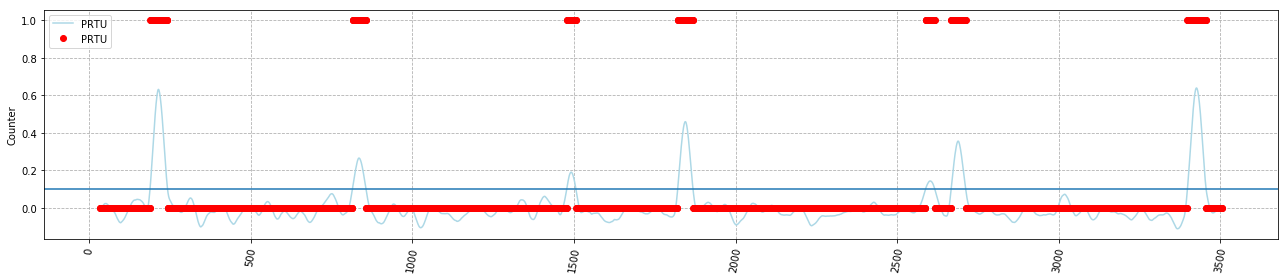

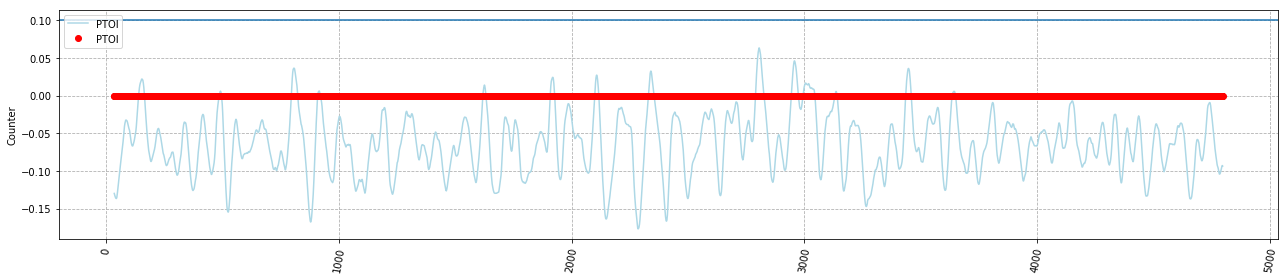

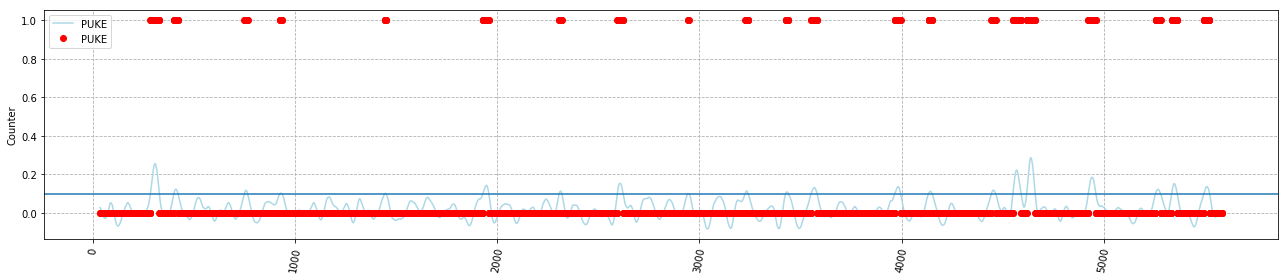

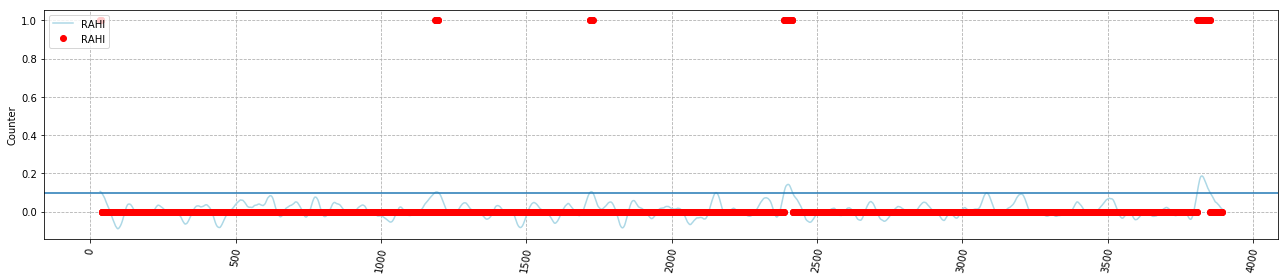

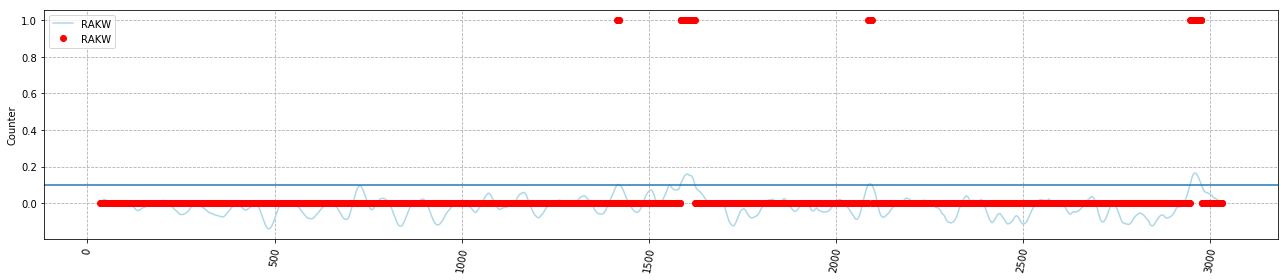

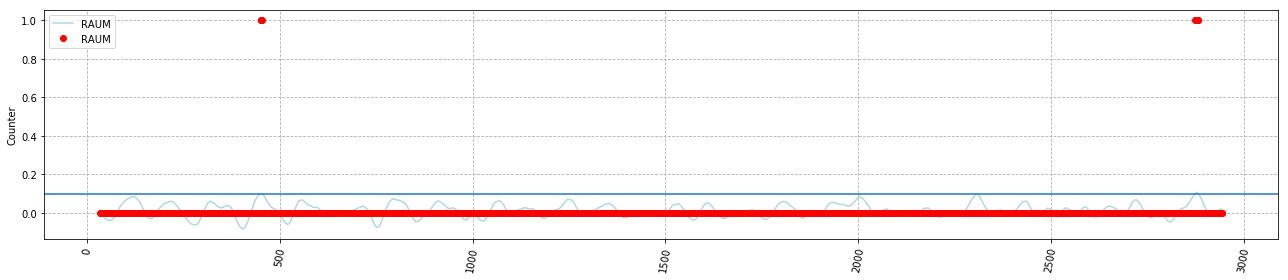

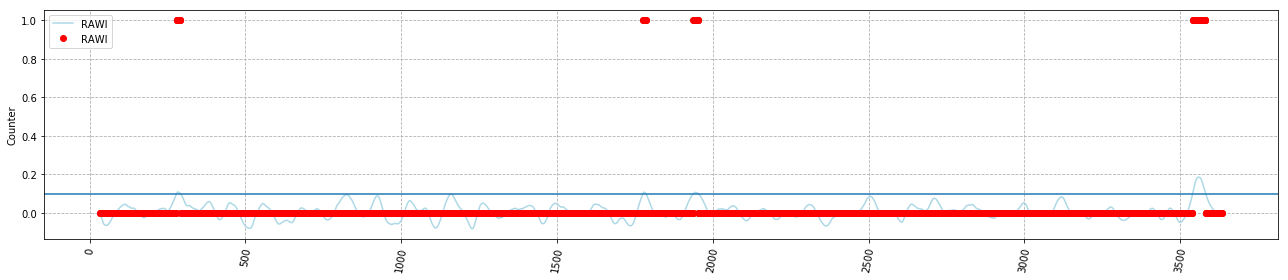

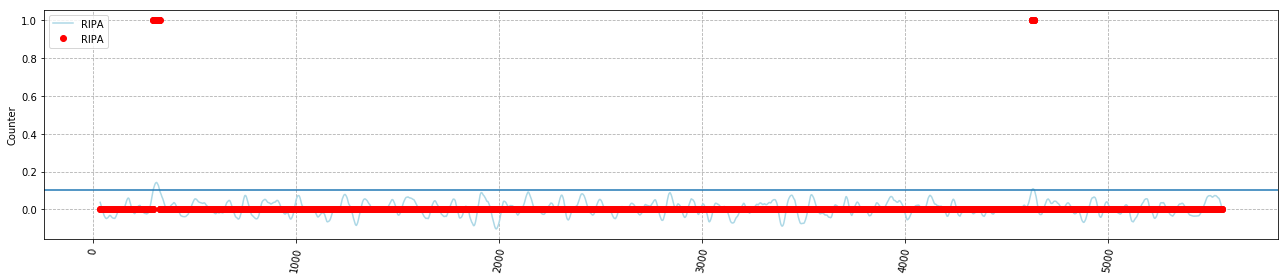

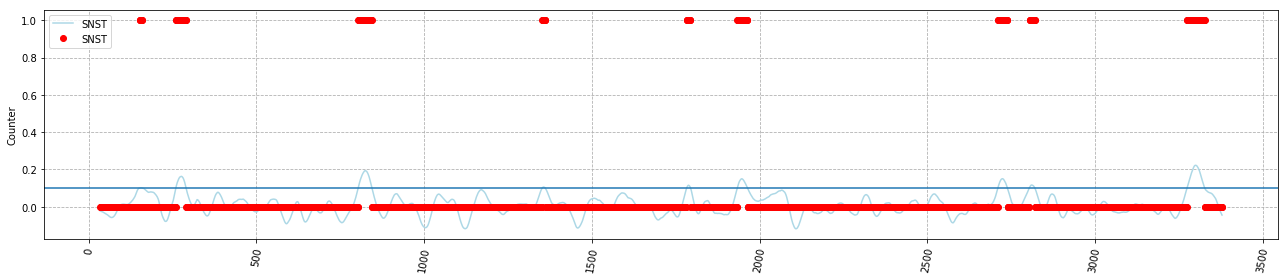

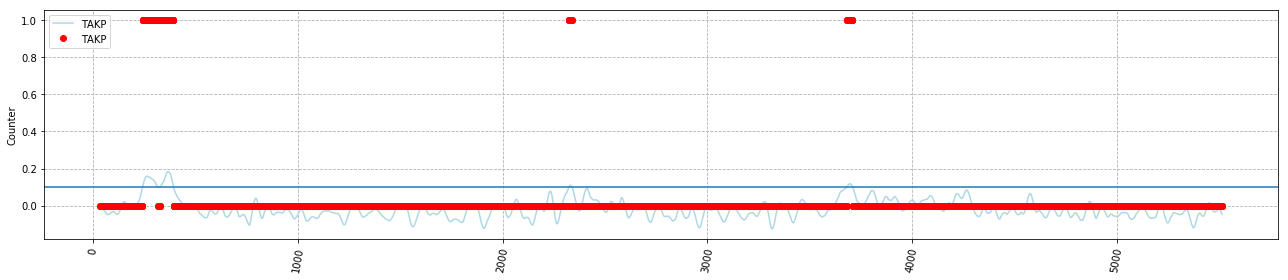

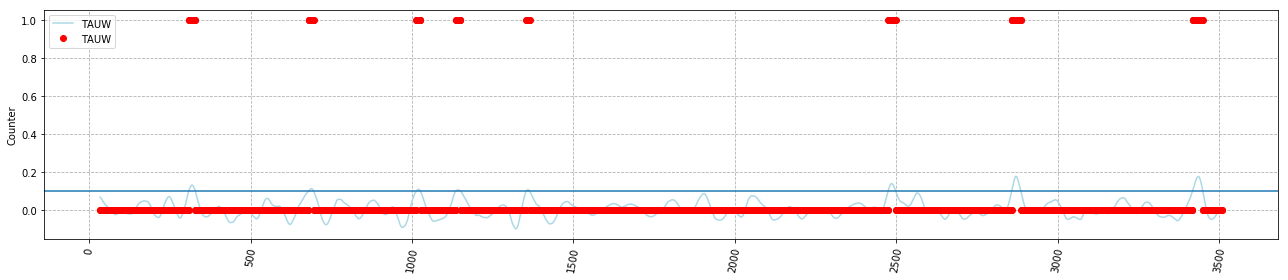

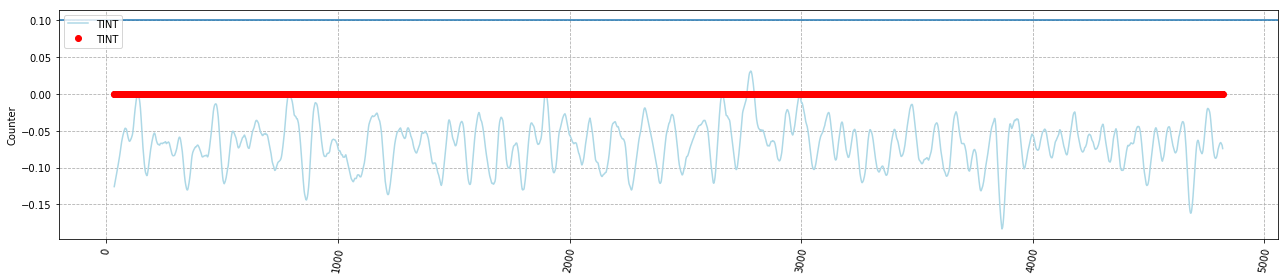

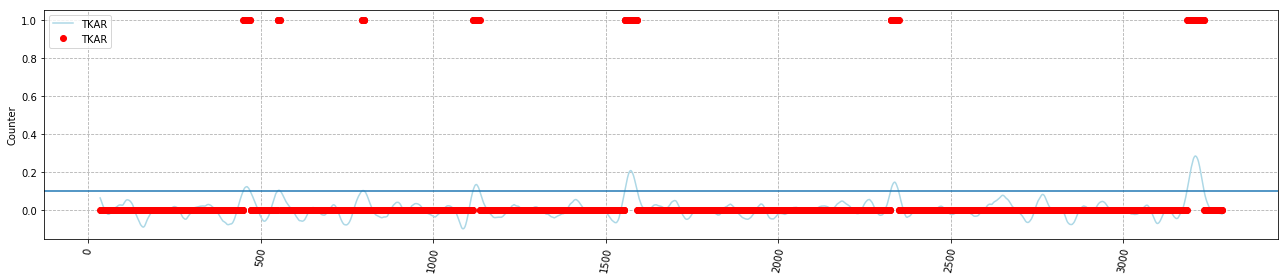

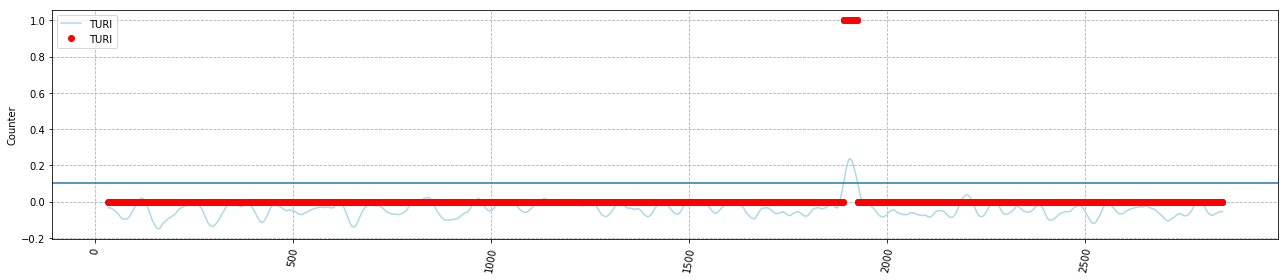

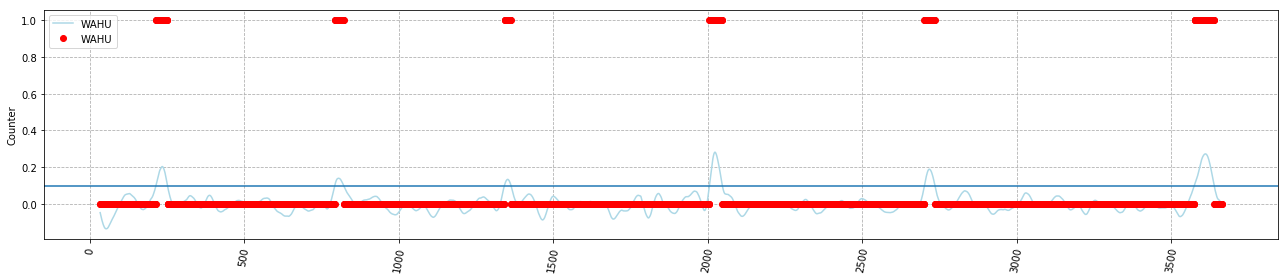

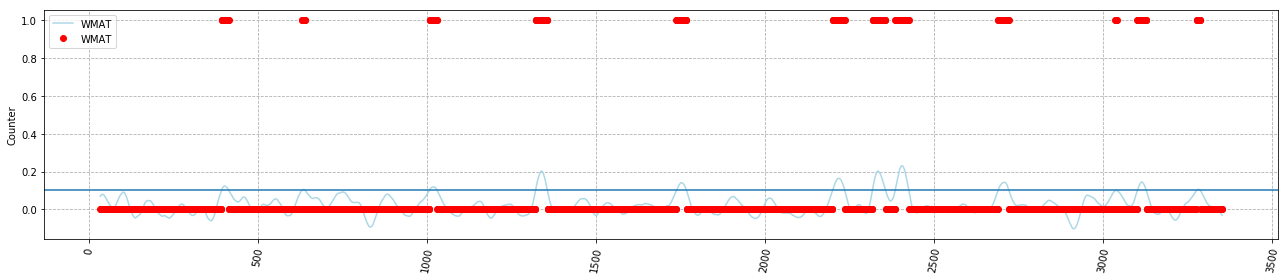

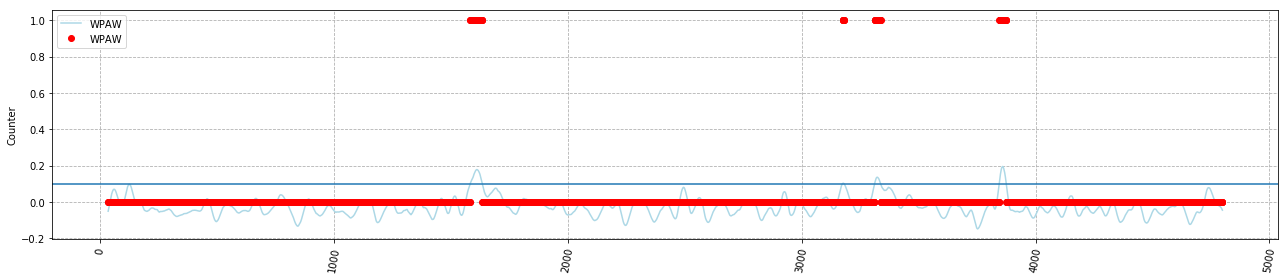

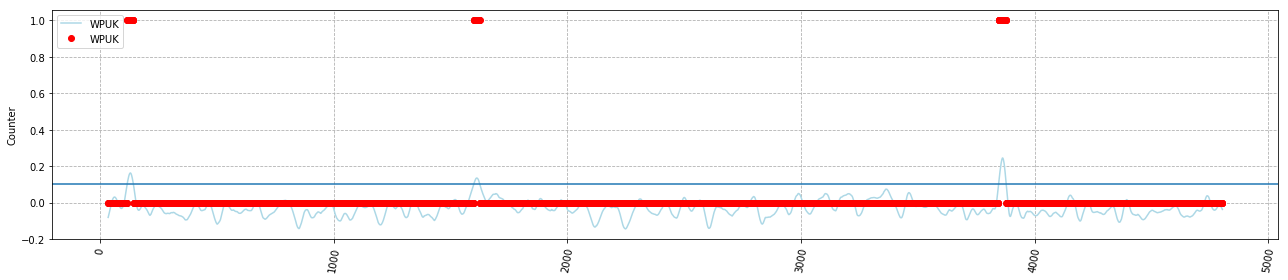

In [13]:
for i in stations_list:
#     globals()['slope_{0}'.format(i)].plot(y="slope",figsize=(20,10),subplots=True,color='tab:orange',layout=(3,1),label=i)
    
    plt.figure()
    plt.plot(globals()['slope_{0}'.format(i)].index,globals()['slope_{0}'.format(i)]['rolling'],'-', color='lightblue',label=i)
    plt.plot(globals()['slope_{0}'.format(i)].index,globals()['slope_{0}'.format(i)]['Event'],'o', color='red',label=i)
    # plt.plot_date(visitors2['Date'],visitors2['Visitors'].rolling(5).mean(),'g-',label="Unique Visitors- mean")

    # plt.axvline(x='2018-07-31', color='r', linestyle='--',label="CWB turn off")
    plt.legend(loc=2)
    plt.xticks( rotation= 80 )

    # Grids
    plt.gca().xaxis.grid(True, linestyle='--')
    plt.gca().yaxis.grid(True, linestyle='--')

    plt.ylabel('Counter')
    plt.axhline(0.1)
    
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
    fig_size[0] = 18
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size

    plt.tight_layout()
    plt.plot()

In [13]:
# def Join_DF(slope,df):
#     """
#     This function clean the main DataFrame from the first 70 points
#     and then add the column Event.
#     """
#     df = df.iloc[69:]

#     slope = slope.iloc[34:]

#     df = df.reset_index()
#     slope= slope.reset_index()

#     df['Events'] = pd.Series(slope['Event'])
    
#     return(df)

In [14]:
def Join_DF_test(slope,dfE,dfN,dfU):
    """
    This function clean the main DataFrame from the first 70 points
    and then add the column Event.
    """
    dfE_2 = dfE.copy()
    dfN_2 = dfN.copy()
    dfU_2 = dfU.copy()
    
    slope_2 = slope.copy()
    
    dfE_2 = dfE_2.iloc[69:]
    dfN_2 = dfN_2.iloc[69:]
    dfU_2 = dfU_2.iloc[69:]
    slope_2 = slope_2.iloc[34:]

    dfE_2 = dfE_2.reset_index()
    dfN_2 = dfN_2.reset_index()
    dfU_2 = dfU_2.reset_index()   
    slope_2 = slope_2.reset_index()

    dfE_2['n'] = pd.Series(dfN_2['x'])
    dfE_2['n_error'] = pd.Series(dfN_2['error'])
    dfE_2['u'] = pd.Series(dfU_2['x'])
    dfE_2['u_error'] = pd.Series(dfU_2['error'])
    dfE_2['Events'] = pd.Series(slope_2['Event'])
    
    final = dfE_2
    return(final)

In [15]:
for i in stations_list:
    globals()['final_{0}'.format(i)] = Join_DF_test(globals()['slope_{0}'.format(i)],globals()['stationsE_{0}'.format(i)]
                                              ,globals()['stationsN_{0}'.format(i)]
                                              ,globals()['stationsU_{0}'.format(i)])


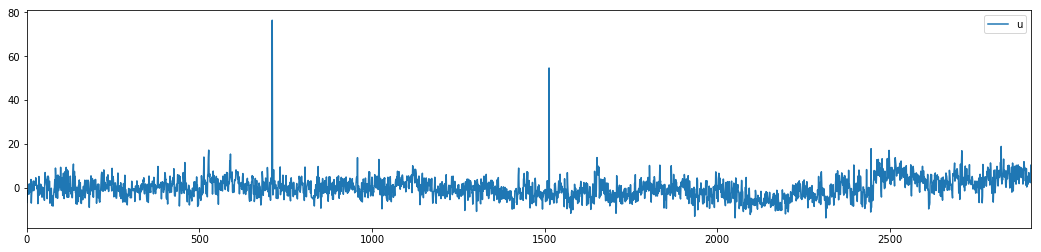

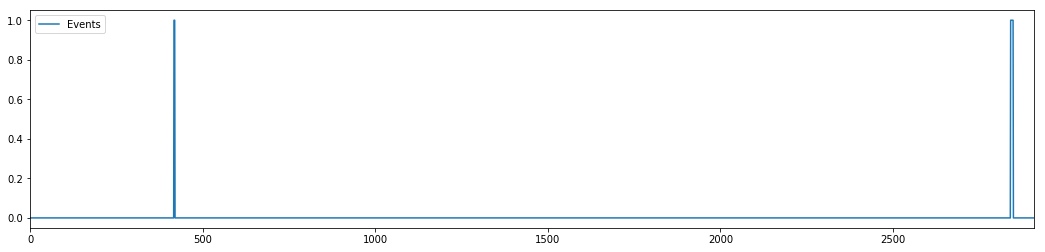

In [16]:
final_RAUM.plot(y=['u'])
final_RAUM.plot(y=['Events'])

In [17]:


def Input_Generator(df,input_data):
    """
    This function generate an input from all the station for a multi-layer perceptron NN
    """
    
    


#     input_data = pd.concat([input_data,df[[ 'x', 'error', 'counter', 'n', 'n_error', 'u', 'u_error','Events']]]) 
    input_data = pd.concat([input_data,df[[ 'x', 'error', 'n', 'n_error', 'u', 'u_error','Events']]]) 

    return(input_data)


In [23]:
columns = [ 'x', 'error', 'n', 'n_error', 'u', 'u_error','Events']
input_data = pd.DataFrame( columns=columns)

for i in stations_list:
    input_data = Input_Generator(globals()['final_{0}'.format(i)],input_data)
input_data = input_data.reset_index(drop=True)
input_data.to_csv('input_data.csv', sep='\t', encoding='utf-8',index=False)

In [24]:
input_data.head()

x  error      n  n_error      u  u_error  Events
0 -12.05   1.75 -90.64     1.87  -8.74     6.55     0.0
1 -12.37   1.77 -90.88     1.90 -10.80     6.64     0.0
2 -12.90   1.70 -90.59     1.83  -7.54     6.46     0.0
3 -12.97   1.75 -90.55     1.87 -11.04     6.55     0.0
4 -12.67   1.81 -91.53     1.94  -9.73     6.81     0.0

In [27]:
dataset = pd.read_csv('input_data.csv', sep='\t', encoding='utf-8')

dataset.head()
# # split into input (X) and output (Y) variables

# train_X = dataset.drop(columns=['Events'])

# #one-hot encode target column
# train_Y = to_categorical(dataset.Events)


# #get number of columns in training data
# n_cols = train_X.shape[1]


x  error      n  n_error      u  u_error  Events
0 -12.05   1.75 -90.64     1.87  -8.74     6.55     0.0
1 -12.37   1.77 -90.88     1.90 -10.80     6.64     0.0
2 -12.90   1.70 -90.59     1.83  -7.54     6.46     0.0
3 -12.97   1.75 -90.55     1.87 -11.04     6.55     0.0
4 -12.67   1.81 -91.53     1.94  -9.73     6.81     0.0

# Data cleaning: Missing values in time

In [20]:
columns = [ 'x', 'error', 'counter', 'n', 'n_error', 'u', 'u_error','Events']
input_data = pd.DataFrame( columns=columns)


input_data = pd.concat([input_data,final_AHTI[[ 'x', 'error', 'counter', 'n', 'n_error', 'u', 'u_error','Events']]]) 
input_data = pd.concat([input_data,final_AKTO[[ 'x', 'error', 'counter', 'n', 'n_error', 'u', 'u_error','Events']]]) 

In [21]:
input_data.count()

x          8315
error      8315
counter    8315
n          8315
n_error    8315
u          8315
u_error    8315
Events     8315
dtype: int64

In [22]:
# data = stations_MAKO.resample('D').mean().interpolate(method='piecewise_polynomial')
# data = stations_MAKO.asfreq('D')
# res = s.resample('s').interpolate().resample('15T').asfreq().dropna()


## Quick check to see how manny stations have gaps

In [23]:
# gappy_stations = []
# for i in stations_list:
#     globals()['stations_{0}'.format(i)]  = (globals()['stations_{0}'.format(i)]).asfreq('D')
    
#     if globals()['stations_{0}'.format(i)].isnull().any().any() == True:
#             gappy_stations.append(i) 
#             globals()['stations_{0}'.format(i)]= globals()['stations_{0}'.format(i)].fillna(-20)
# print(gappy_stations)

In [24]:
# print(data.to_string(),stations_SNST)
# print(data.to_string())
